# Mod 4 Project - Real Estate Investment

This project is an analysis of zip codes within the Greater Austin Area to determine which five zip codes provide the best investment. For this project, the best investment will be defined as the largest return on investment (ROI) over a 5 year period. The data for this project comes from the zillow_data.csv file included in this repository.

# Greater Austin Area
The Greater Austin Area is composed of 30 cities spanning 5 counties, containing a total of 71 separate zip codes. It is the fourth largest metropolitan area in Texas, and 35th largest in the US, with approximately 1.7 Million people as of the 2010 Census, expanding to an estimated 2.1 Million in 2018.


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import itertools

from flatiron_time_series import *

In [2]:
data = pd.read_csv('zillow_data.csv')
data = data[(data.Metro == 'Austin') & (data.State == 'TX')]
data

RegionID  RegionName          City State   Metro  CountyName  SizeRank  \
18        92593       78660  Pflugerville    TX  Austin      Travis        19   
32        92551       78613    Cedar Park    TX  Austin  Williamson        33   
66        92617       78704        Austin    TX  Austin      Travis        67   
77        92598       78666    San Marcos    TX  Austin        Hays        78   
98        92654       78745        Austin    TX  Austin      Travis        99   
...         ...         ...           ...   ...     ...         ...       ...   
10440     92585       78652    San Leanna    TX  Austin      Travis     10441   
10970     92557       78619     Driftwood    TX  Austin        Hays     10971   
12221     92592       78659         Paige    TX  Austin     Bastrop     12222   
12831     92588       78655    Martindale    TX  Austin    Caldwell     12832   
12908     91454       76530       Granger    TX  Austin  Williamson     12909   

        1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  2017-10  \
18     138900.0  138600.0  138400.0  ...   235000   235900   236600   237400   
32     169600.0  169000.0  168600.0  ...   291400   291700   292700   294400   
66     221300.0  221100.0  221000.0  ...   530100   532400   534200   536200   
77     103100.0  103000.0  103000.0  ...   193400   193200   193600   195200   
98     135000.0  134200.0  133800.0  ...   286300   286900   287500   288700   
...         ...       ...       ...  ...      ...      ...      ...      ...   
10440  144600.0  144600.0  144700.0  ...   303600   304400   306400   307700   
10970  298000.0  298000.0  297900.0  ...   475900   474200   474200   476300   
12221   54300.0   55000.0   55700.0  ...   165200   168000   171100   172800   
12831   68600.0   69000.0   69400.0  ...   204700   209300   212300   215200   
12908       NaN       NaN       NaN  ...   150300   149100   149600   147800   

       2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
18      238500   239400   240000   241000   242200   242800  
32      295800   296200   295900   296400   297500   297300  
66      538200   539800   540200   542300   547100   550900  
77      196900   197500   197900   200100   203800   206500  
98      289800   290500   291300   292600   294000   294700  
...        ...      ...      ...      ...      ...      ...  
10440   307600   306700   306400   307400   309400   310800  
10970   478700   479400   478100   482100   497500   513000  
12221   173500   175100   175800   177300   181400   185700  
12831   216500   217100   217700   219500   221600   222300  
12908   145200   144700   145500   152600   161700   163800  

[73 rows x 272 columns]

# Step 2: Data Preprocessing

In [3]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 
                                  'SizeRank'], var_name='Month', value_name = 'MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format = '%Y-%m-%d')
    melted = melted.dropna(subset=['MeanValue'])
    return melted

def get_datetimes(df,start_col=1):
    return pd.to_datetime(df.columns.values[start_col:], format='%Y-%m')

In [4]:
austin_df = pd.DataFrame()
austin_df['Month'] = get_datetimes(data, 7)

for zipcode in data.RegionName:
    row = data[data.RegionName==zipcode].iloc[:,7:]
    austin_df[zipcode] = row.values[0]
austin_df.set_index('Month', inplace=True)

In [5]:
Trav_zc = list(data[data.CountyName == 'Travis']['RegionName'])
Will_zc = list(data[data.CountyName == 'Williamson']['RegionName'])
Hays_zc = list(data[data.CountyName == 'Hays']['RegionName'])
Bast_zc = list(data[data.CountyName == 'Bastrop']['RegionName'])
Cald_zc = list(data[data.CountyName == 'Caldwell']['RegionName'])

In [6]:
summary_df = pd.DataFrame()
summary_df['Region'] = austin_df.mean(axis = 1)
summary_df['Travis'] = austin_df[Trav_zc].mean(axis = 1)
summary_df['Williamson'] = austin_df[Will_zc].mean(axis = 1)
summary_df['Hays'] = austin_df[Hays_zc].mean(axis = 1)
summary_df['Bastrop'] = austin_df[Bast_zc].mean(axis = 1)
summary_df['Caldwell'] = austin_df[Cald_zc].mean(axis = 1)

# Step 3: EDA and Visualization

In [7]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

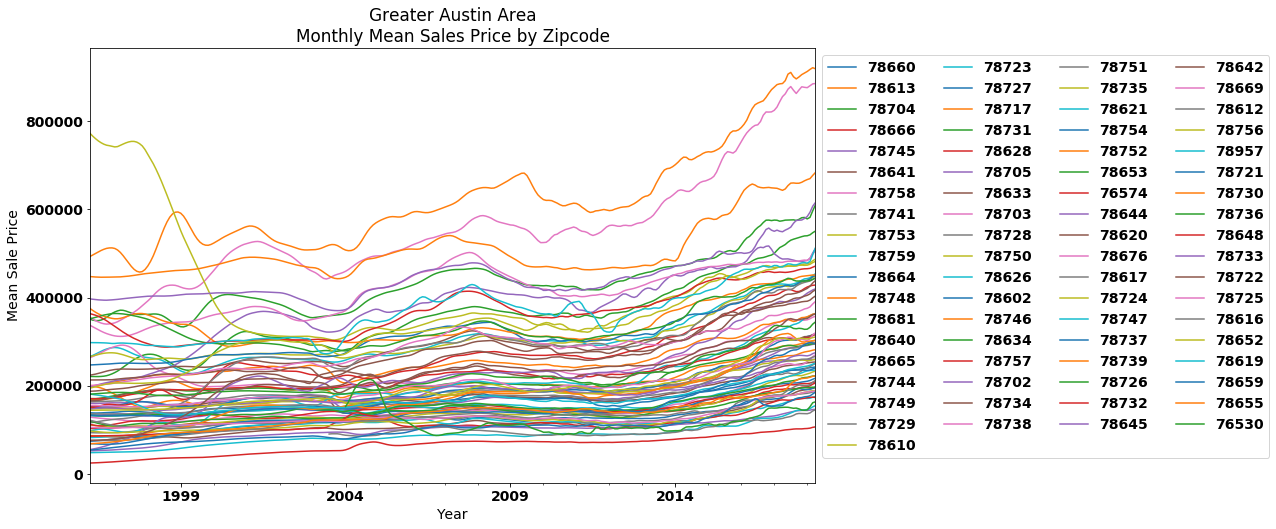

In [8]:
austin_df.plot(figsize = (13,8))
plt.legend(bbox_to_anchor = (1,1), ncol = 4)
plt.xlabel('Year')
plt.ylabel('Mean Sale Price')
plt.title('Greater Austin Area\nMonthly Mean Sales Price by Zipcode')
plt.show()

While we are aware of the 2008 housing bubble crash, it appears from this graph that most of the zip codes in the Greater Austin Area weren't overly affected, outside of the 10 or so highest cost areas. Despite the lack of change, we still want to focus on more recent trends, so we'll cut off all but the last 6 years, as that's about when the more recent trends started, and work from there.

In [466]:
austin_df = austin_df['2012':]
austin_df.head()

78660     78613     78704     78666     78745     78641  \
Month                                                                    
2012-01-01  165600.0  199100.0  363400.0  136000.0  170400.0  165000.0   
2012-02-01  165500.0  199400.0  364700.0  136500.0  170800.0  165100.0   
2012-03-01  165000.0  199400.0  365100.0  137400.0  170600.0  165200.0   
2012-04-01  164700.0  200000.0  365500.0  138200.0  170500.0  165600.0   
2012-05-01  165100.0  201100.0  366500.0  139000.0  171300.0  166000.0   

               78758     78741     78753     78759  ...    78648     78733  \
Month                                               ...                      
2012-01-01  138700.0  138000.0  128500.0  296400.0  ...  71700.0  434200.0   
2012-02-01  138500.0  138400.0  128600.0  297700.0  ...  71700.0  437500.0   
2012-03-01  138100.0  138500.0  128800.0  299000.0  ...  71900.0  439500.0   
2012-04-01  137500.0  138900.0  128700.0  300600.0  ...  72200.0  442100.0   
2012-05-01  137200.0  139400.0  128100.0  301900.0  ...  72400.0  444100.0   

               78722     78725    78616     78652     78619     78659  \
Month                                                                   
2012-01-01  264300.0  116500.0  88500.0  187600.0  321700.0  110800.0   
2012-02-01  265400.0  115800.0  88800.0  188700.0  323100.0  110500.0   
2012-03-01  267700.0  116800.0  88900.0  189800.0  330700.0  110900.0   
2012-04-01  269200.0  117300.0  88900.0  190700.0  342100.0  111300.0   
2012-05-01  269200.0  117500.0  89200.0  191300.0  349700.0  111000.0   

               78655     76530  
Month                           
2012-01-01  140800.0  107300.0  
2012-02-01  139400.0  105000.0  
2012-03-01  138800.0  102500.0  
2012-04-01  139300.0  102600.0  
2012-05-01  139800.0  104100.0  

[5 rows x 73 columns]

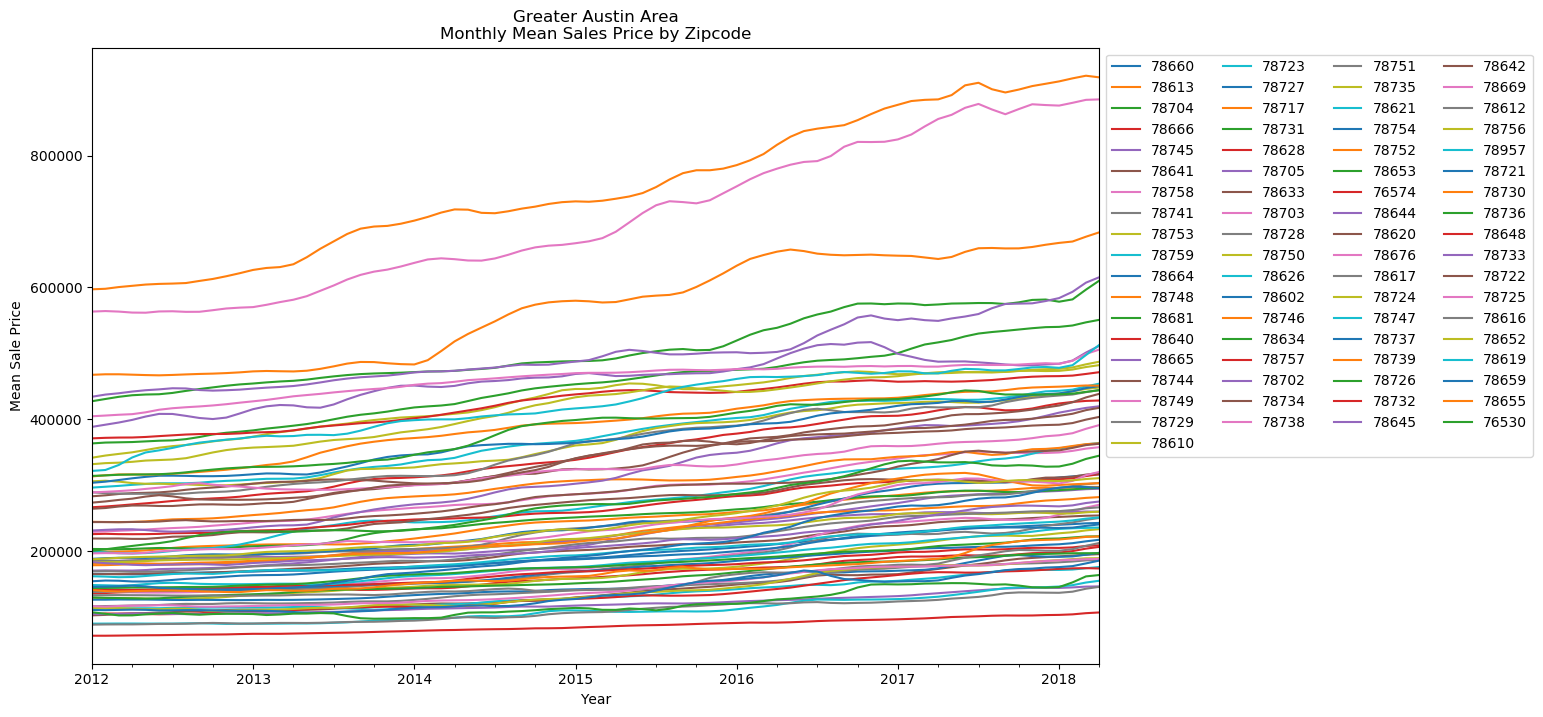

In [467]:
austin_df.plot(figsize = (13,8))
plt.legend(bbox_to_anchor = (1,1), ncol = 4)
plt.xlabel('Year')
plt.ylabel('Mean Sale Price')
plt.title('Greater Austin Area\nMonthly Mean Sales Price by Zipcode')
plt.show()

Text(0, 0.5, 'Mean Sale Price')

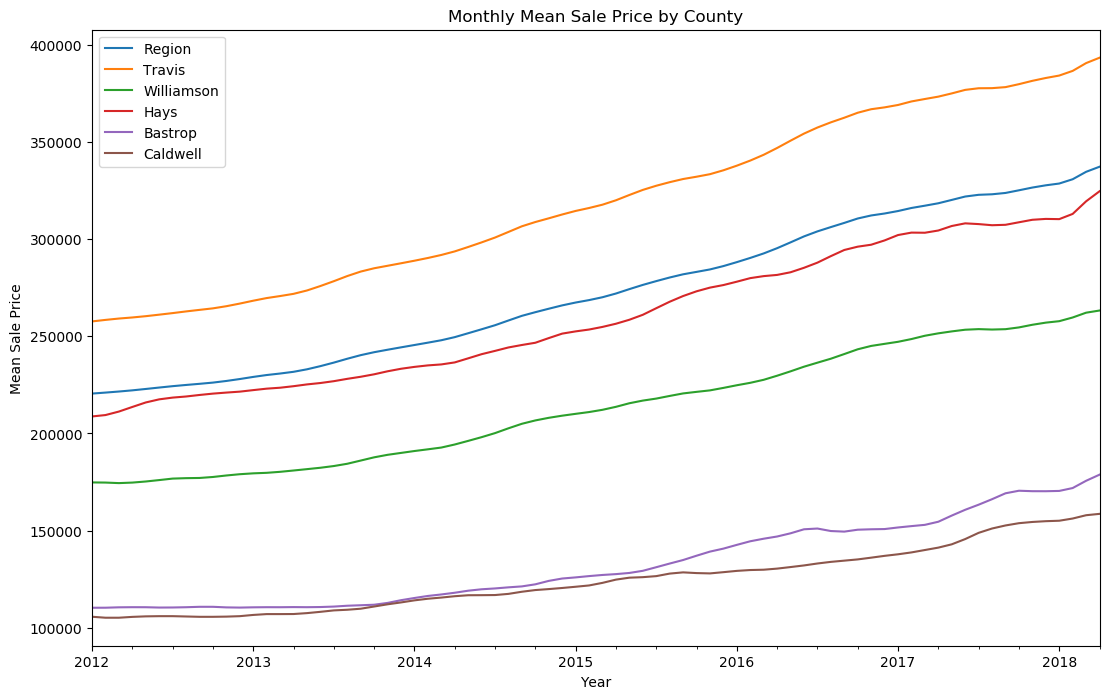

In [468]:
summary_df = summary_df['2012':]
summary_df.plot(figsize = (13,8), legend = True)
plt.title('Monthly Mean Sale Price by County')
plt.xlabel('Year')
plt.ylabel('Mean Sale Price')

# Step 4: ARIMA Modeling

#### Train/Test Split

In [469]:
train_df, test_df = summary_df[:'2016-09'].Region, summary_df['2016-10':].Region
print(len(train_df))
print(len(test_df))

57
19


### Seasonal Decomposition
To investigate the trend and seasonality, we'll get the mean values for each county and run a seasonal decomposition on each dataset to get a visual idea of which model type we'll need to use.

In [383]:
decomposition = seasonal_decompose(np.log(summary_df))

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

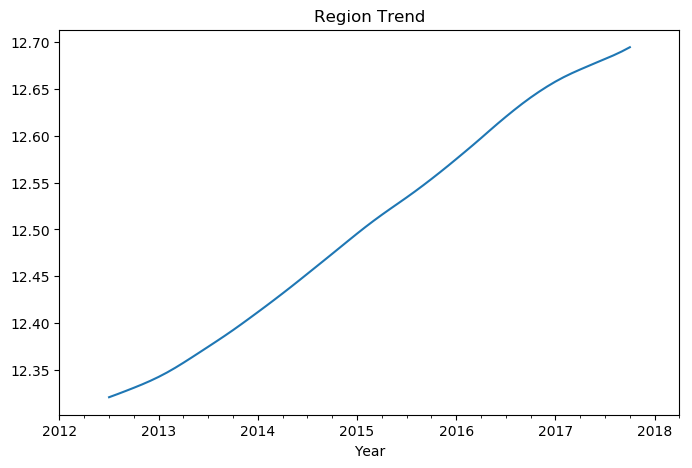

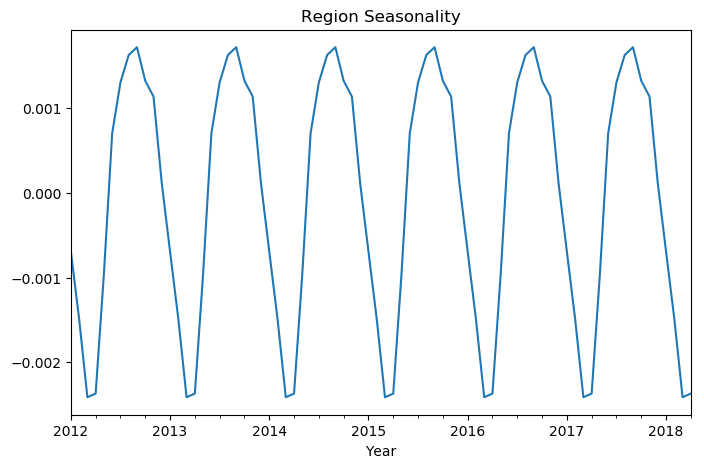

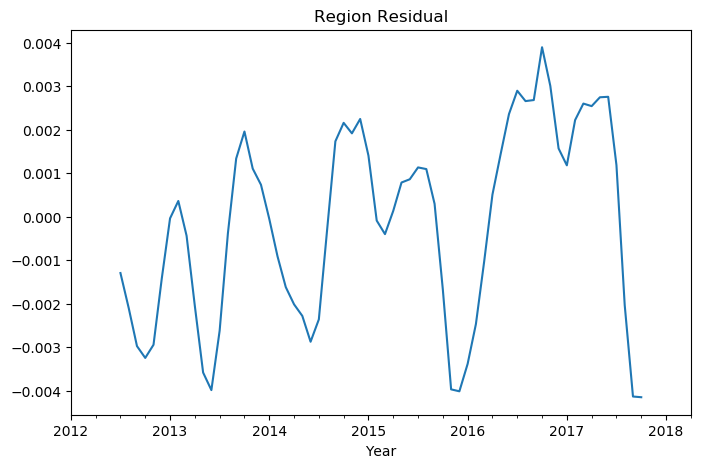

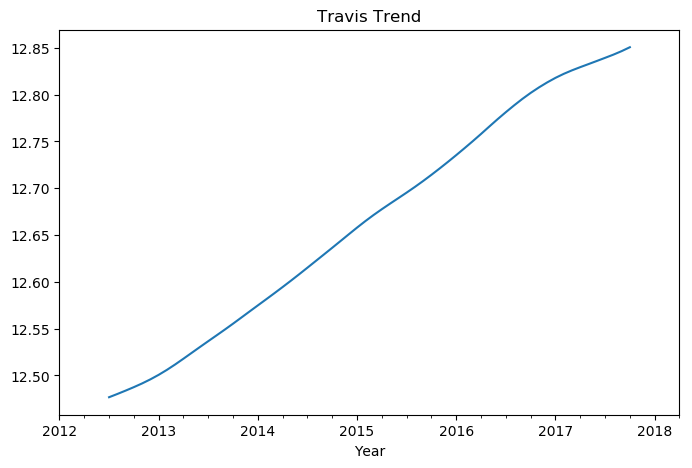

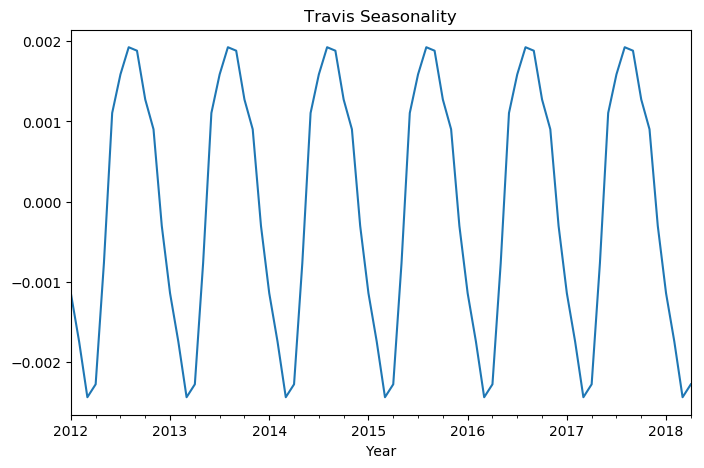

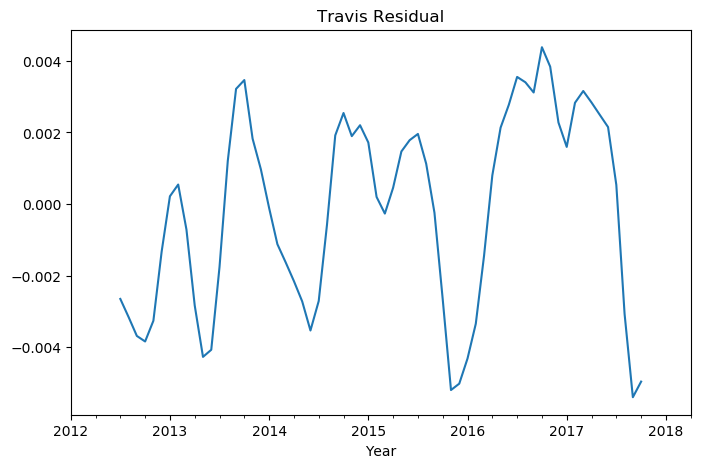

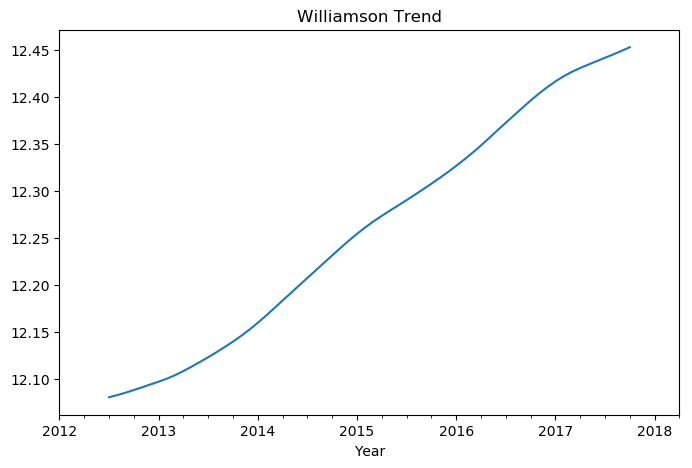

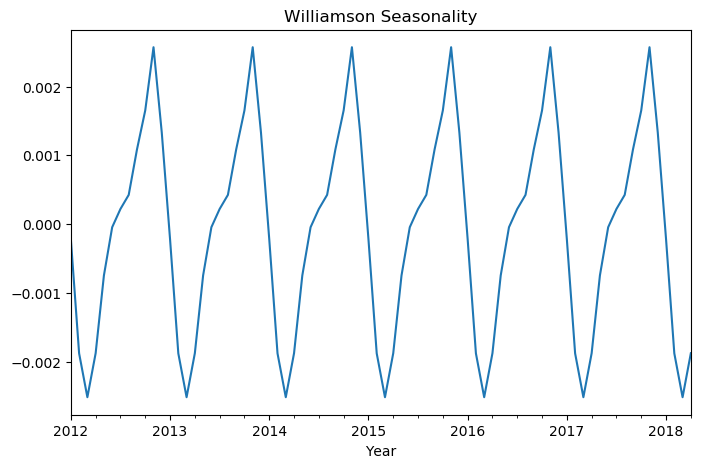

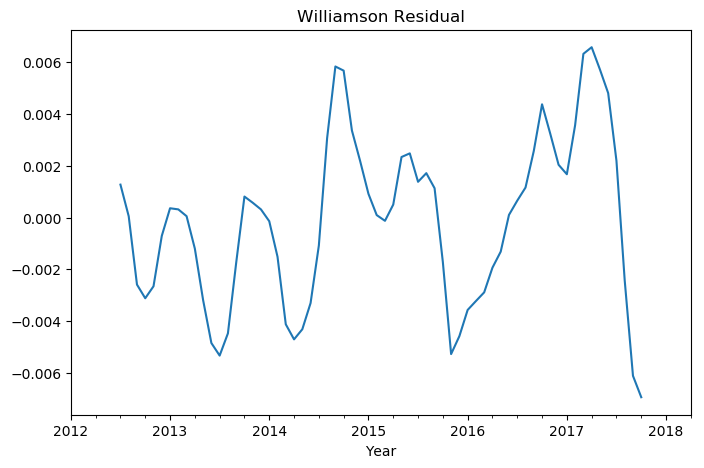

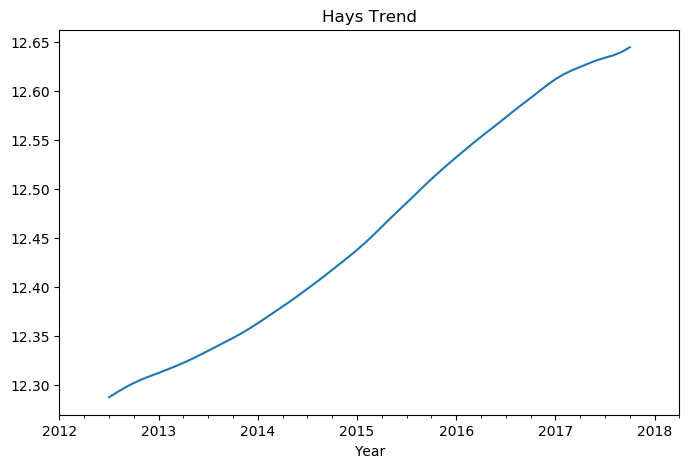

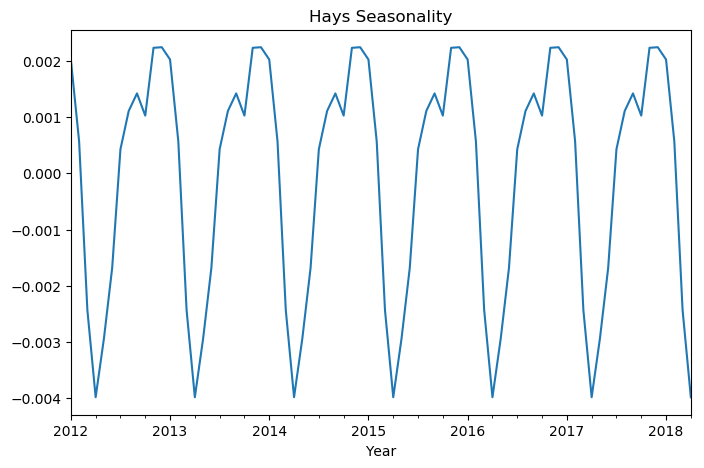

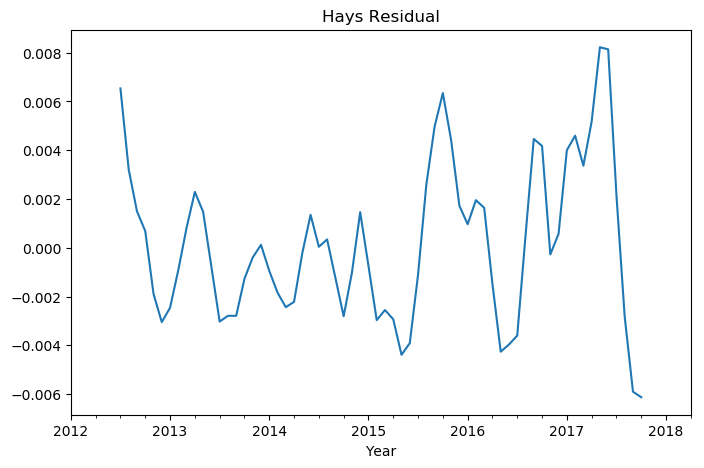

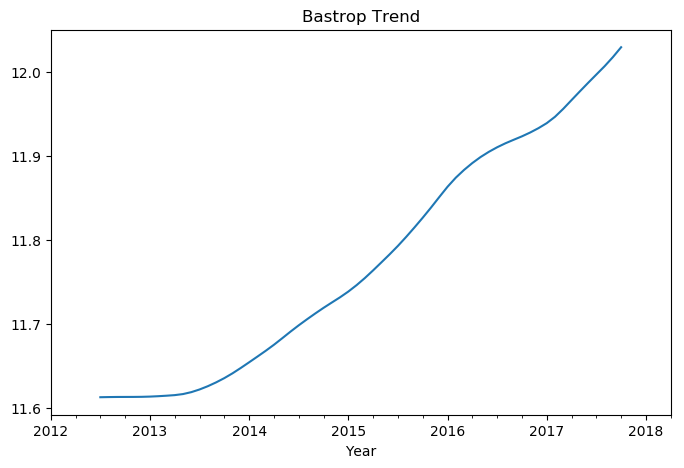

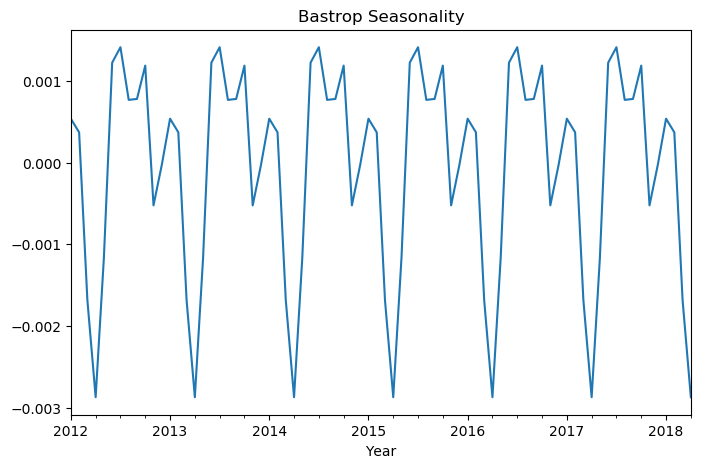

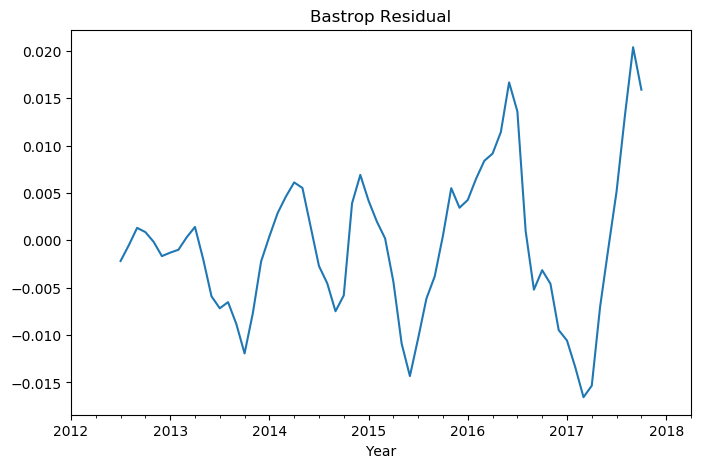

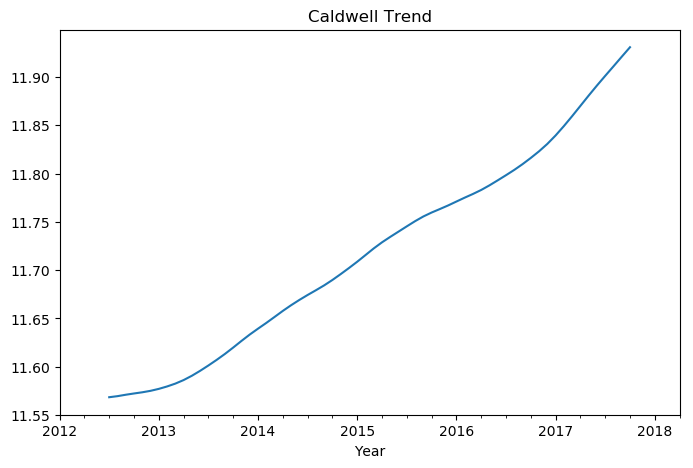

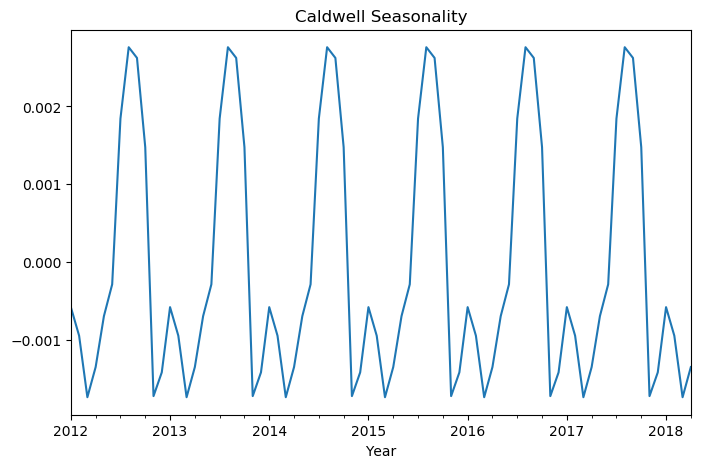

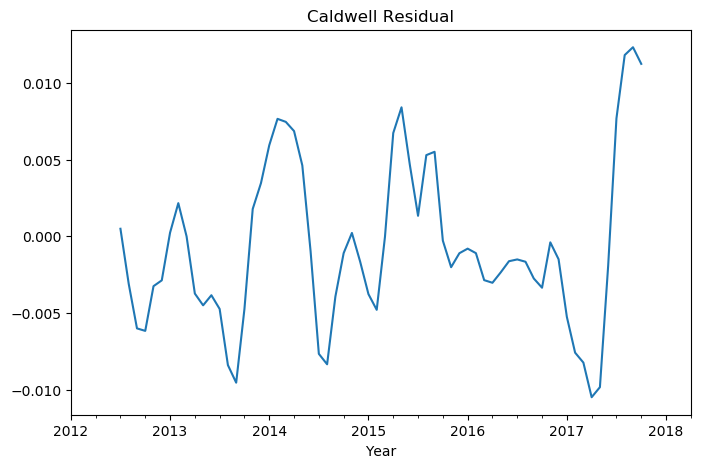

In [439]:
for county in summary_df.columns:
    trend[county].plot(figsize = (8,5))
    plt.title(county + ' Trend')
    plt.xlabel('Year')
    plt.show();

    seasonal[county].plot(figsize = (8,5))
    plt.title(county + ' Seasonality')
    plt.xlabel('Year')
    plt.show();

    residual[county].plot(figsize = (8,5))
    plt.title(county + ' Residual')
    plt.xlabel('Year')
    plt.show();

### Testing various SARIMA parameters

In [397]:
p = [0,1,2,3]
d = [0,1]
q = [0,1,2,3]

sp = [0,1,2]
sd = [0,1]
sq = [0,1,2]
s = [12]

In [401]:
results = get_SARIMA_parameters(train_df,p,d,q,sp,sd,sq,s)
results[0:10]

total combos =  576


[{'terms': (3, 1, 0),
  'seasonal terms': (2, 1, 0, 12),
  'AIC': 234.0815107952603},
 {'terms': (0, 1, 1),
  'seasonal terms': (2, 1, 0, 12),
  'AIC': 303.5974569455062},
 {'terms': (0, 1, 0),
  'seasonal terms': (2, 1, 0, 12),
  'AIC': 315.91129077461767},
 {'terms': (0, 0, 0),
  'seasonal terms': (2, 1, 0, 12),
  'AIC': 387.0425417363895},
 {'terms': (0, 0, 0),
  'seasonal terms': (2, 1, 1, 12),
  'AIC': 437.2695325517223},
 {'terms': (0, 1, 1),
  'seasonal terms': (2, 0, 0, 12),
  'AIC': 458.61631272098344},
 {'terms': (0, 0, 1),
  'seasonal terms': (2, 1, 0, 12),
  'AIC': 463.0926502402771},
 {'terms': (0, 0, 2),
  'seasonal terms': (2, 1, 0, 12),
  'AIC': 469.02948533893345},
 {'terms': (0, 1, 1),
  'seasonal terms': (2, 0, 1, 12),
  'AIC': 471.08272805084084},
 {'terms': (0, 1, 1),
  'seasonal terms': (1, 1, 0, 12),
  'AIC': 478.1674239190688}]

In [423]:
pdq = (3, 1, 0)
pdqs = (2, 1, 0, 12)
model = run_SARIMAX(summary_df.Region, pdq, pdqs)['model']
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             Region   No. Observations:                   76
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -265.548
Date:                            Mon, 25 Nov 2019   AIC                            543.097
Time:                                    14:23:56   BIC                            552.598
Sample:                                01-01-2012   HQIC                           546.413
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2698      0.156      8.139      0.000       0.964       1.576
ar.L2         -1.2785      0.266     -4.804      0.000      -1.800      -0.757
ar.L3          0.8616      0.186      4.633      0.000       0.497       1.226
ar.S.L12      -1.0976      0.259     -4.232      0.000      -1.606      -0.589
ar.S.L24      -0.2581      0.280     -0.921      0.357      -0.808       0.291
sigma2      1.495e+05   5.55e+04      2.693      0.007    4.07e+04    2.58e+05
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 1.09
Prob(Q):                               nan   Prob(JB):                         0.58
Heteroskedasticity (H):               2.08   Skew:                            -0.30
Prob(H) (two-sided):                  0.22   Kurtosis:                         2.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

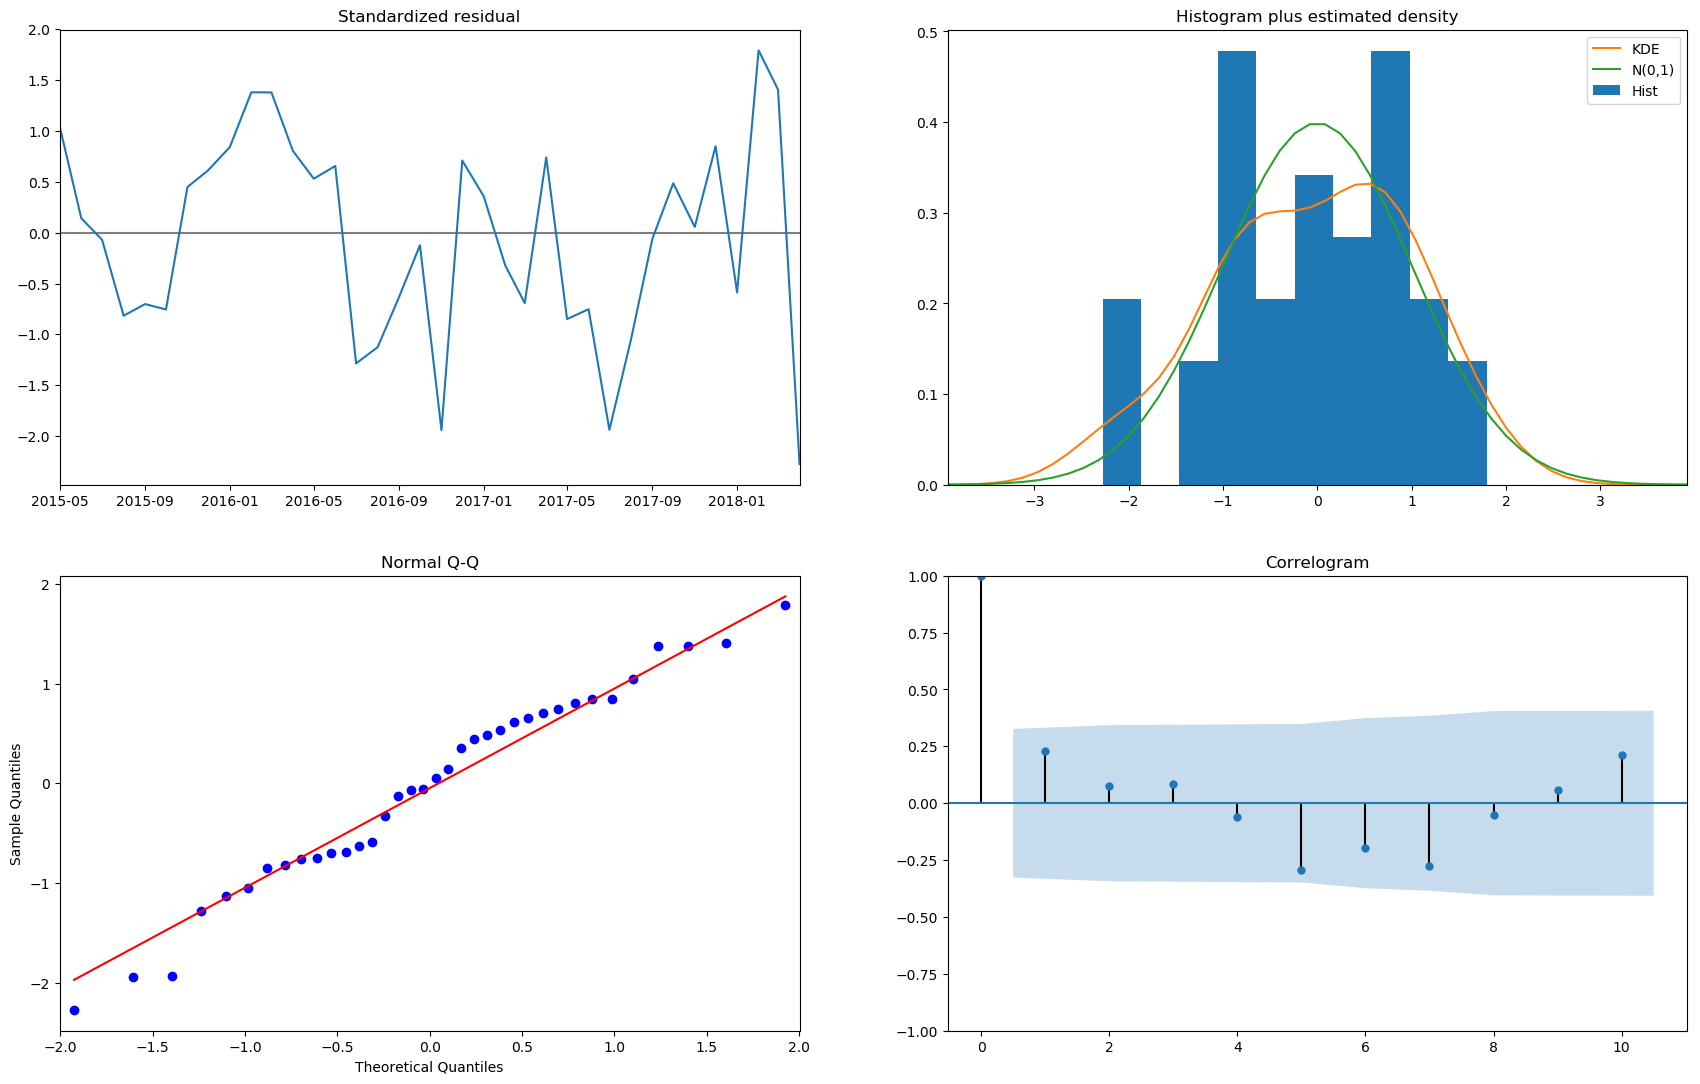

In [429]:
model.plot_diagnostics(figsize = (21,13));

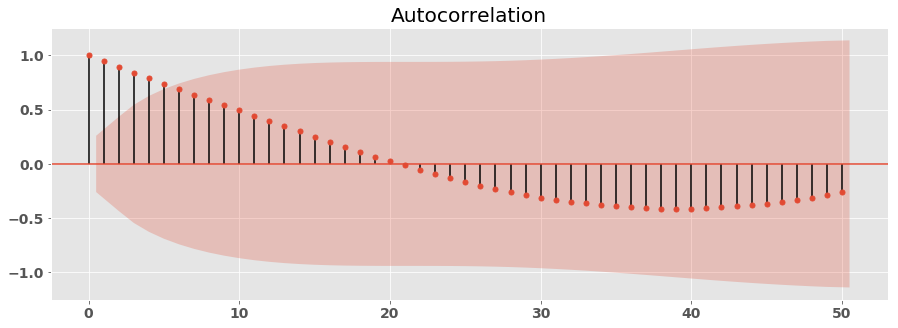

In [409]:
acf_plot(train_df, lags = 50)

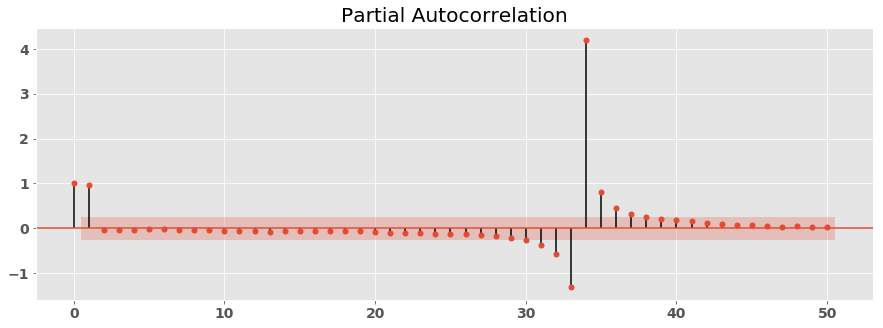

In [408]:
pacf_plot(train_df, lags = 50)

### Plotting predictions with model

RMSE:  417.0225662898892


Text(0, 0.5, 'Mean Sale Price')

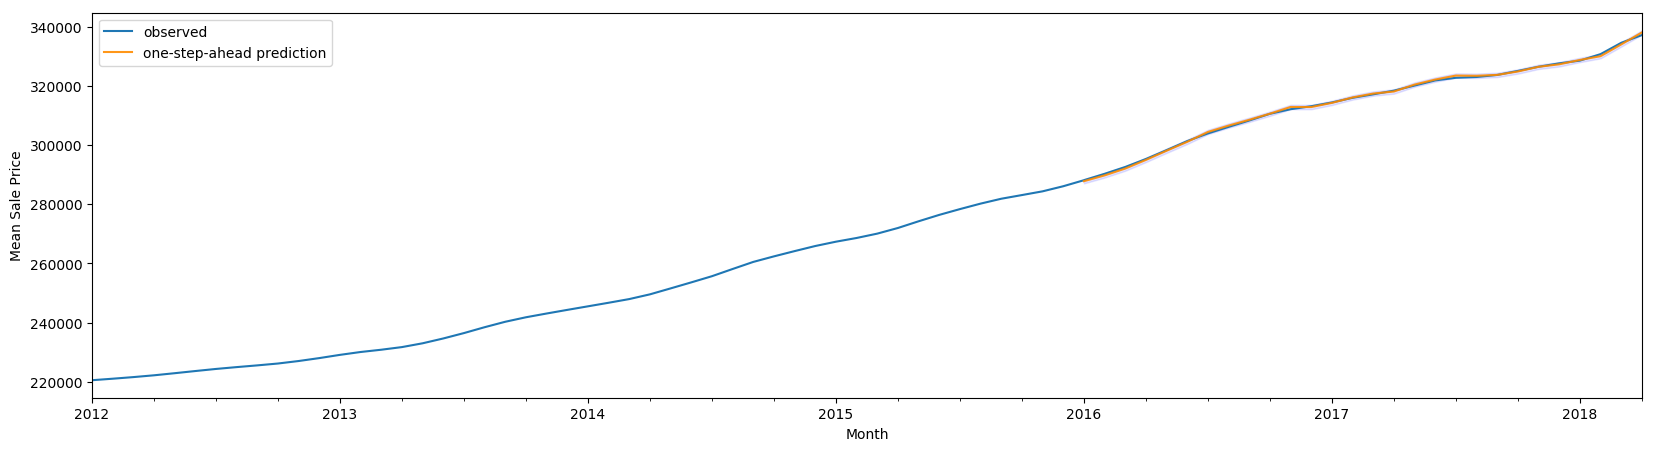

In [428]:
plot_prediction(summary_df.Region, model, '2016', dynamic=False)
plt.ylabel('Mean Sale Price')

RMSE:  3575.8937845430623


Text(0, 0.5, 'Mean Sale Price')

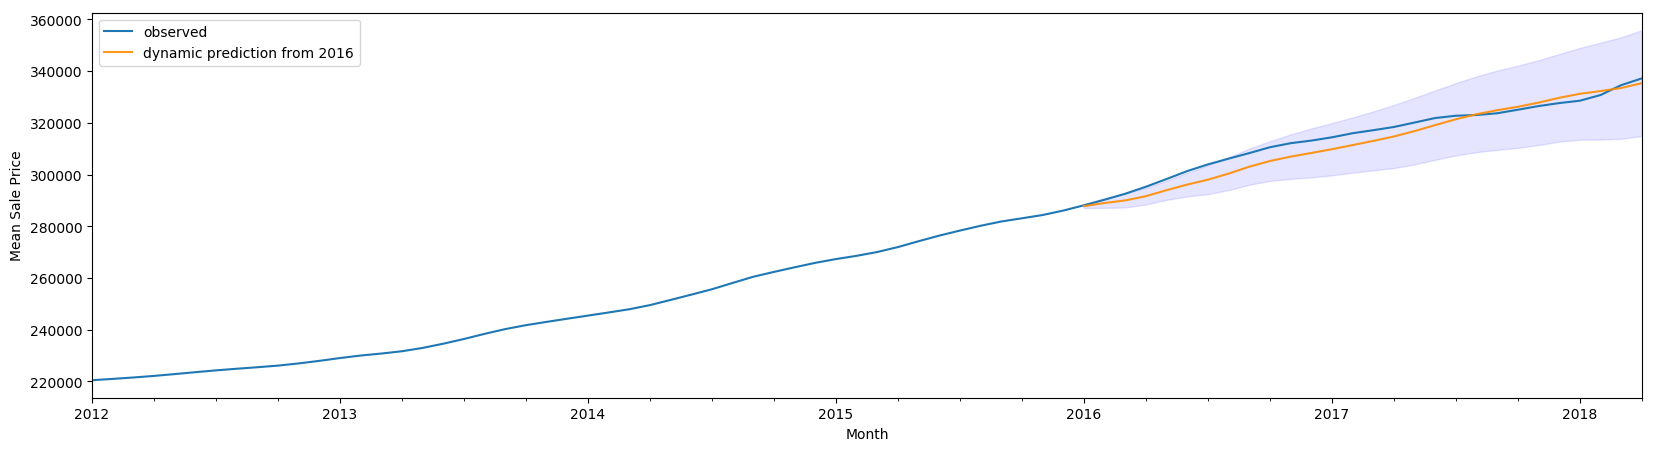

In [427]:
plot_prediction(summary_df.Region, model, '2016', dynamic=True)
plt.ylabel('Mean Sale Price')

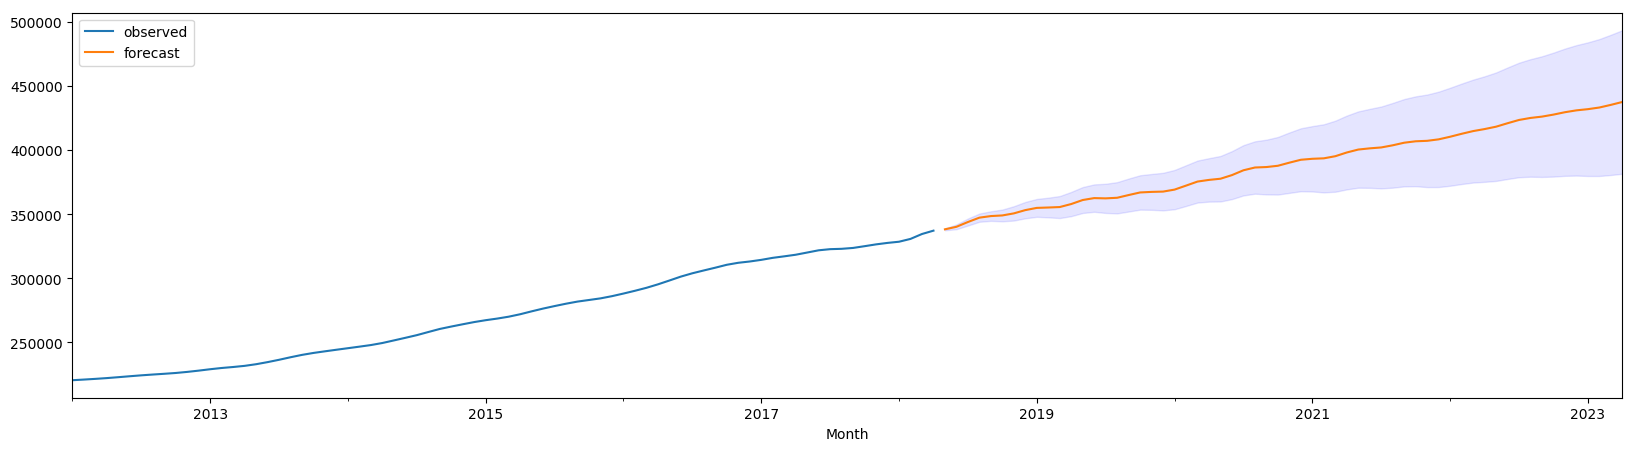

{'ROI_1yr': 0.062, 'ROI_5yr': 0.298}

In [430]:
get_forecast(summary_df.Region, model, 60, plot = True)

# Step 5: Applying Model & Interpreting Results

In [446]:
results = []
steps = 60
for zc in austin_df.columns:
    model = run_SARIMAX(austin_df[zc], pdq, pdqs)['model']
    result = get_forecast(austin_df[zc], model, steps, plot = False)
    result['zipcode'] = zc
    result['model'] = model
    location = data.loc[data.RegionName == zc, ['City', 'State', 'CountyName']].values
    result['city'] = f"{location[0][0]}, {location[0][1]}"
    result['county'] = location[0][2]
    results.append(result)
results = sorted(results, key = lambda x: x['ROI_5yr'], reverse = True)

In [447]:
results_df = pd.DataFrame(results)
results_df.drop(columns = ['model'], inplace = True)
results_df.head()

ROI_1yr  ROI_5yr  zipcode             city   county
0    0.037   15.764    78619    Driftwood, TX     Hays
1    0.023    2.819    78738     Bee Cave, TX   Travis
2    0.162    0.652    78612  Cedar Creek, TX  Bastrop
3    0.169    0.605    78676    Wimberley, TX     Hays
4    0.123    0.560    78741       Austin, TX   Travis

These top two here are outliers, they don't fit the trend of the rest of the results, and therefore will be ignored moving forward.

In [477]:
results.remove(results[0]) #This was run twice

In [478]:
results_df = pd.DataFrame(results)
results_df.drop(columns = ['model'], inplace = True)
results_df.head()

ROI_1yr  ROI_5yr  zipcode             city   county
0    0.162    0.652    78612  Cedar Creek, TX  Bastrop
1    0.169    0.605    78676    Wimberley, TX     Hays
2    0.123    0.560    78741       Austin, TX   Travis
3    0.093    0.545    78957   Smithville, TX  Bastrop
4    0.093    0.542    78758       Austin, TX   Travis

Cedar Creek, TX


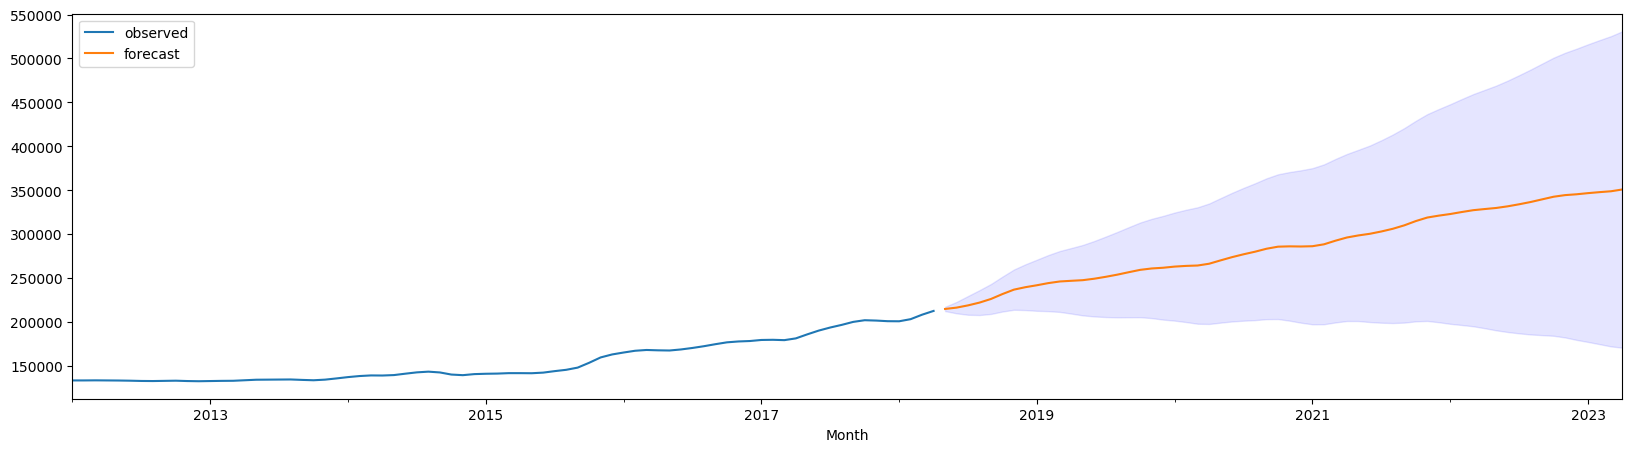

Wimberley, TX


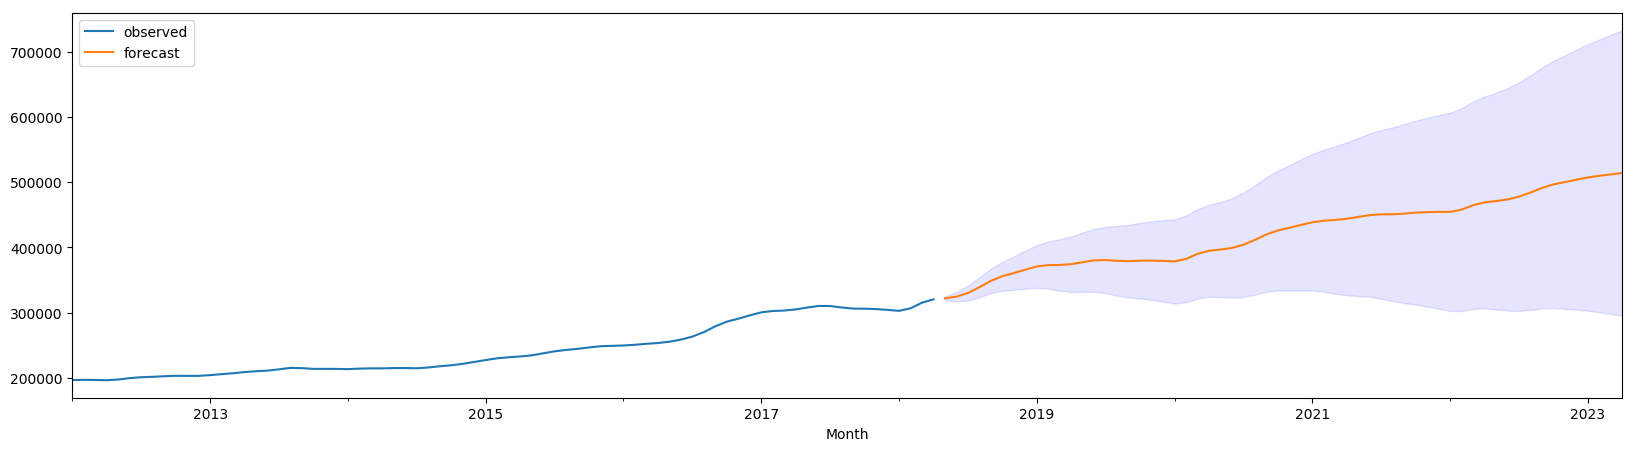

Austin, TX


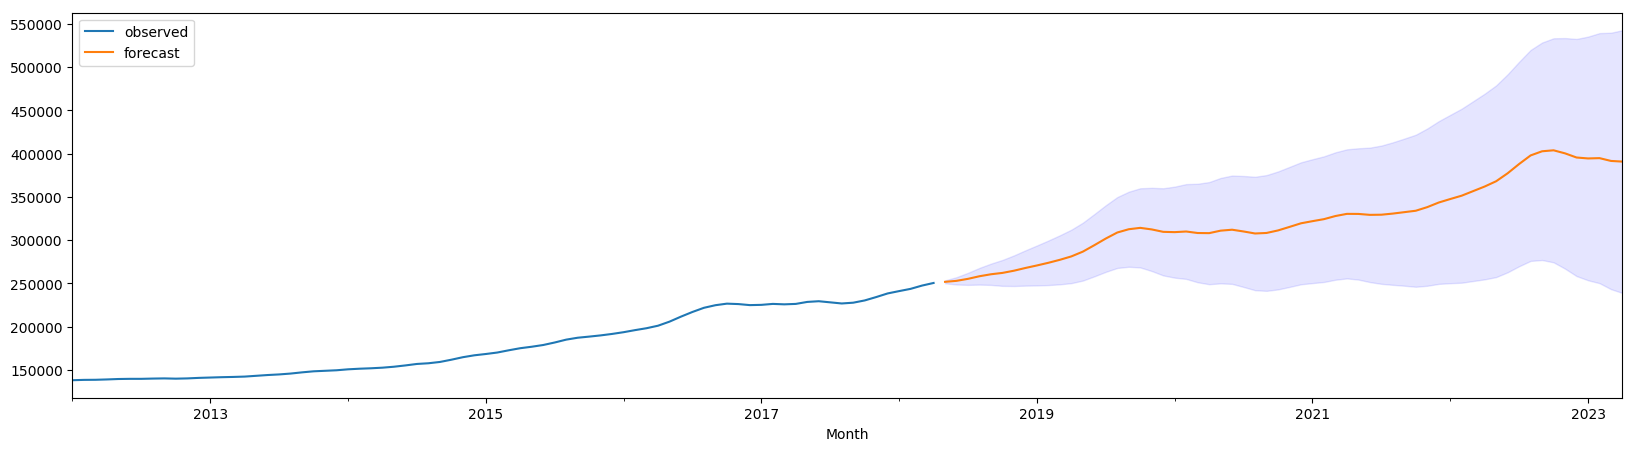

Smithville, TX


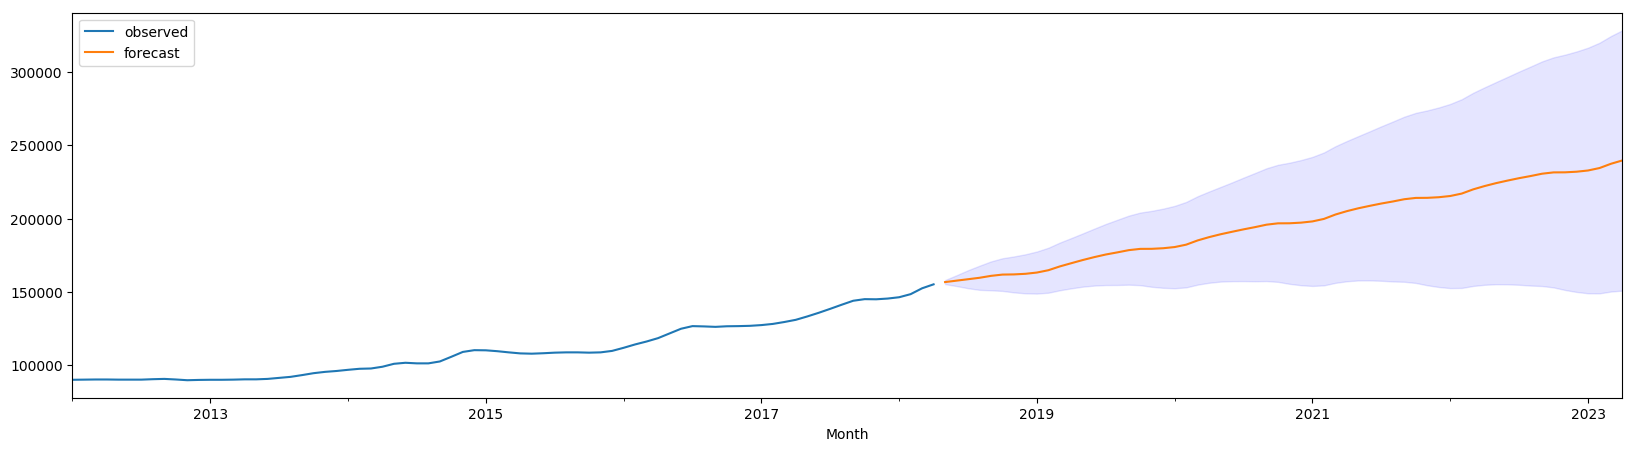

Austin, TX


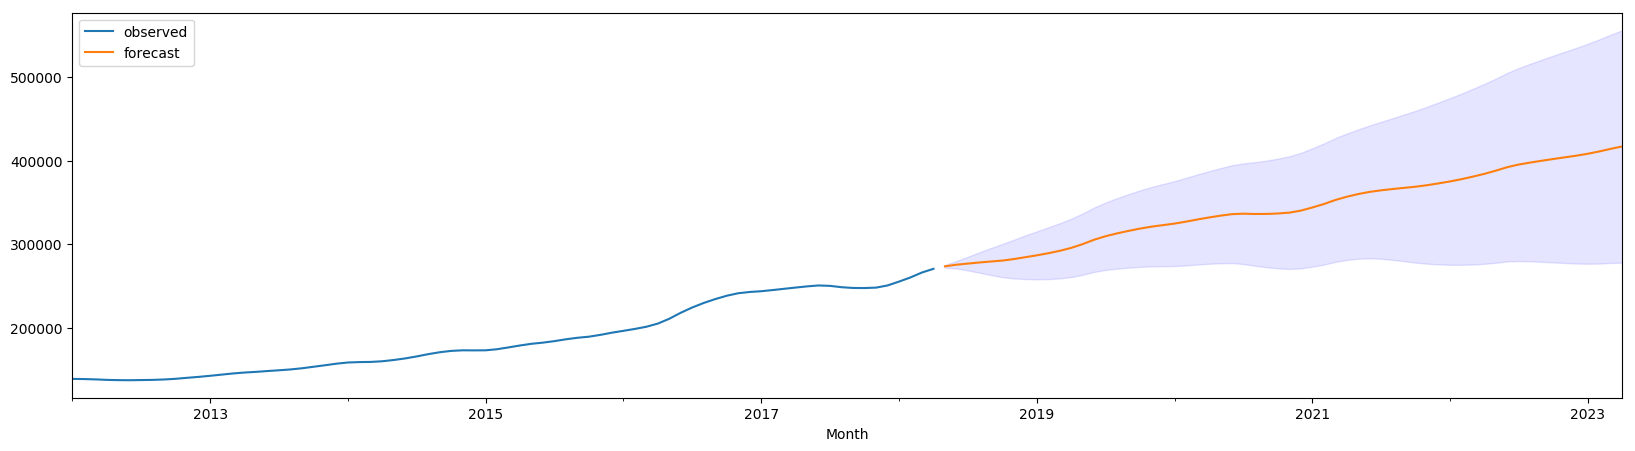

In [479]:
for result in results[:5]:
    print(result['city'])
    get_forecast(austin_df[result['zipcode']], result['model'], 60, plot = True)

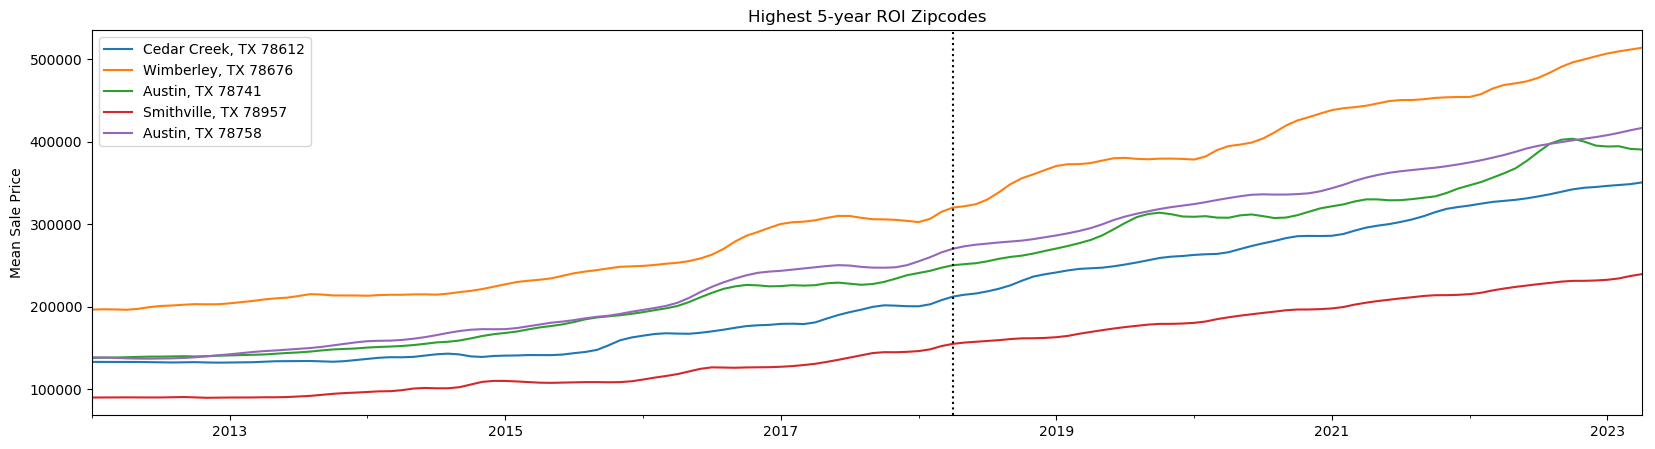

In [485]:
plt.ylabel('Mean Sale Price')
plot_forecasts(austin_df, results[:5], steps = 60, title = 'Highest 5-year ROI Zipcodes')

In [481]:
results_df.tail()

ROI_1yr  ROI_5yr  zipcode            city      county
66    0.012    0.088    78735      Austin, TX      Travis
67    0.028    0.079    78653       Manor, TX      Travis
68   -0.002   -0.052    78665  Round Rock, TX  Williamson
69   -0.084   -0.103    78733      Austin, TX      Travis
70   -0.019   -0.333    78613  Cedar Park, TX  Williamson

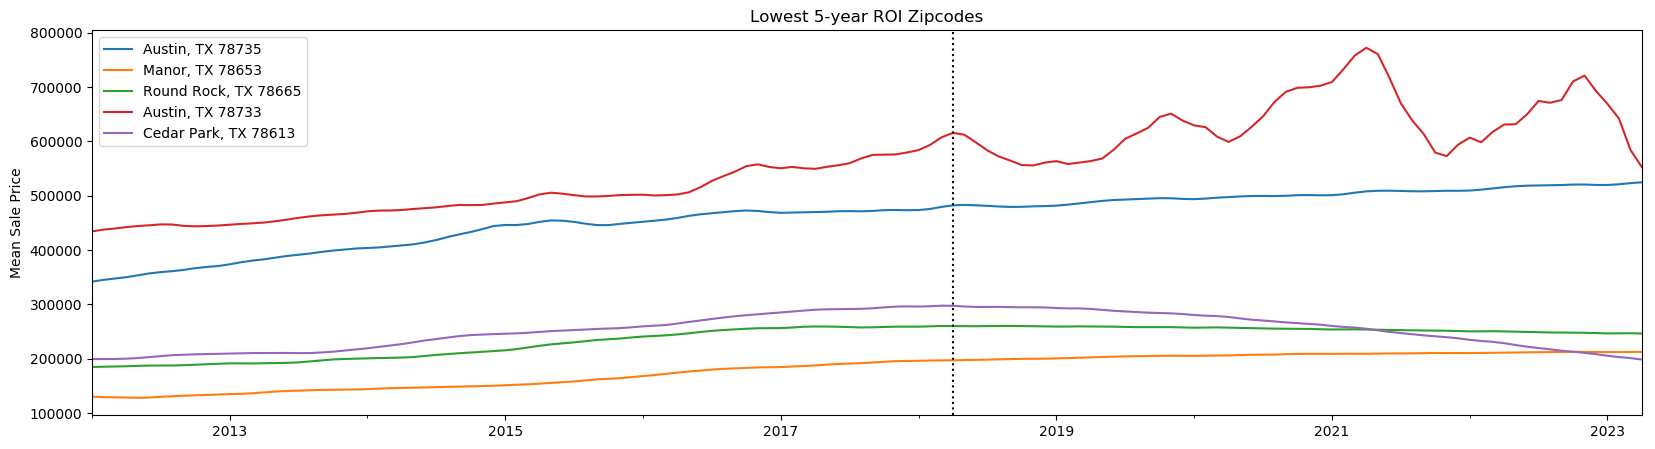

In [490]:
plt.ylabel('Mean Sale Price')
plot_forecasts(austin_df, results[-5:], steps = 60, title = 'Lowest 5-year ROI Zipcodes')

# Conclusion
The best zip codes to invest in, looking at the largest 5-year return on investment, are 78612, 78676, 78741, 78957, and 78758, in that order. Conversely, the five worst zip codes for 5-year ROI are 78735, 78653, 78665, 78733 and 78613, in that order. 

# Future Work
In the future, I'm going to have to look into moving, because I currently live in the 78613 area code. Thankfully I'm just renting, but oh boy do I not want to buy a home here, assuming my modeling was all correct.

I also need to continue to explore how time series work, because I felt like I was fumbling my way through most of this project, and while I do feel comfortable with the results I obtained, I'm nowhere near comfortable in my workflow just yet.

# Step 6: Double Checking?
Yep, double checking. Earlier I commented on how the 2008 housing bubble didn't seem to have too much of an effect, but despite that I was still going to focus on more recent trends. Well, after thinking on this for a bit, I've decided to go ahead and do another round of processing with the full dataset from 1996 on, and see what effect that has on my outcomes. Because of that, I've gone ahead and reset both my austin_df and summary_df to the full set, not limiting them to 2012 and later, and we'll go ahead and work through Steps 4 and 5 one more time with the full sets.

In [11]:
train_df, test_df = summary_df[:'2012-09'].Region, summary_df['2012-10':].Region
print(len(train_df))
print(len(test_df))

198
67


In [12]:
decomposition = seasonal_decompose(np.log(summary_df))

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

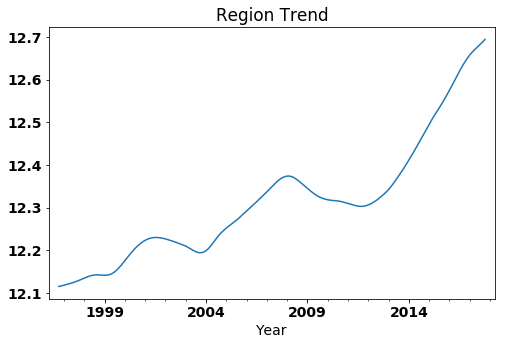

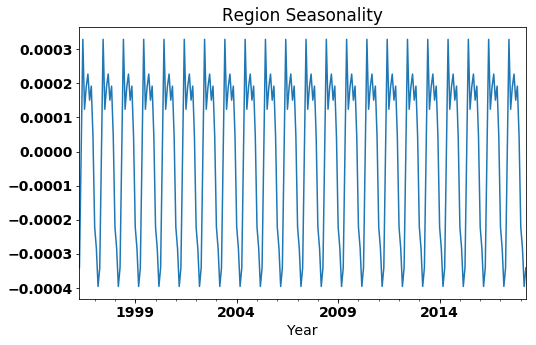

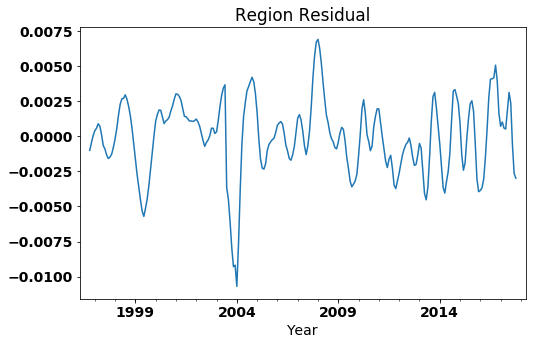

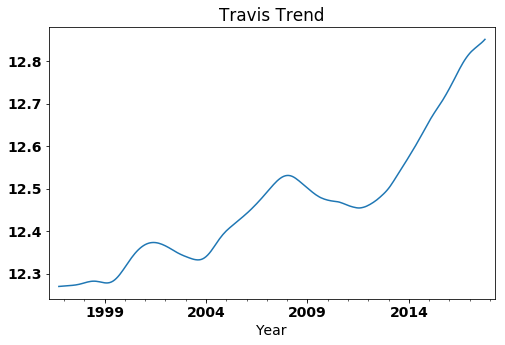

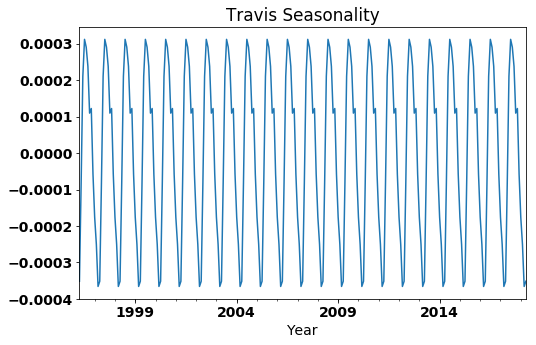

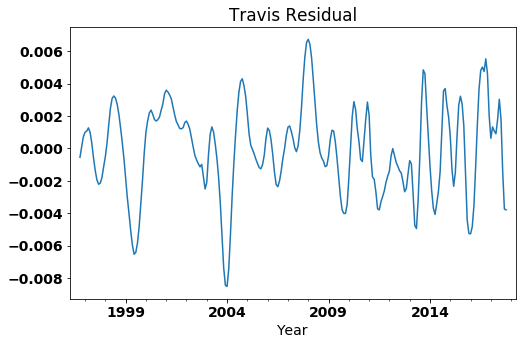

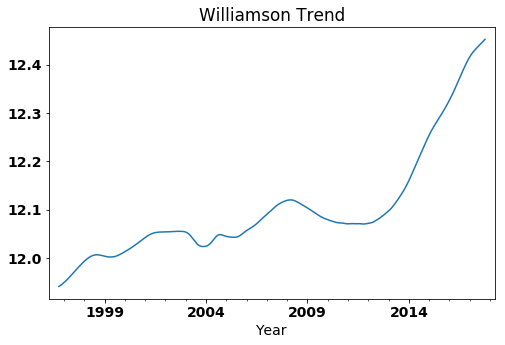

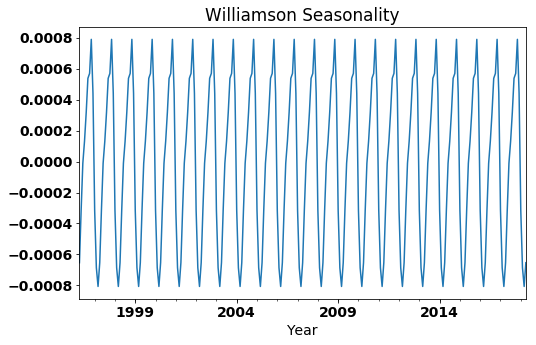

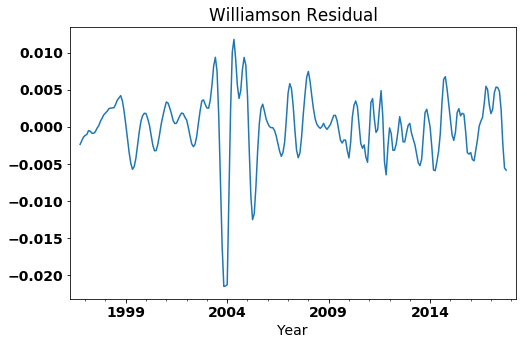

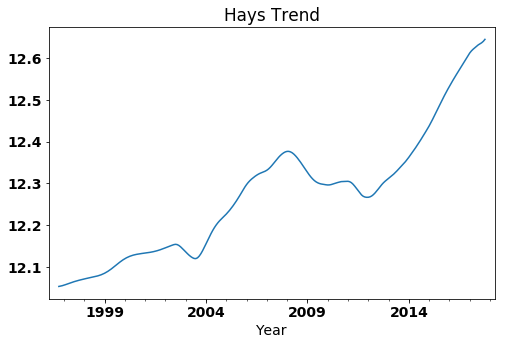

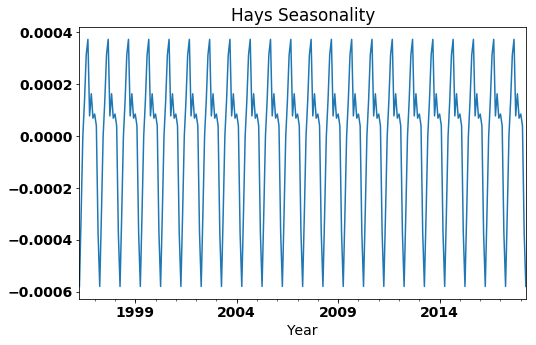

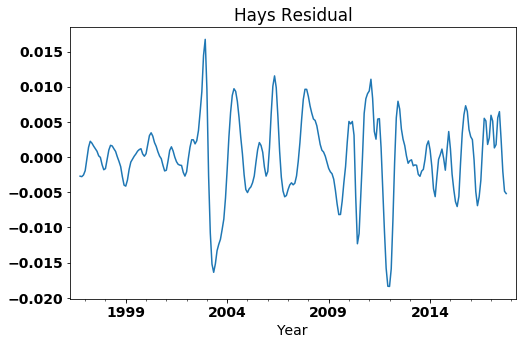

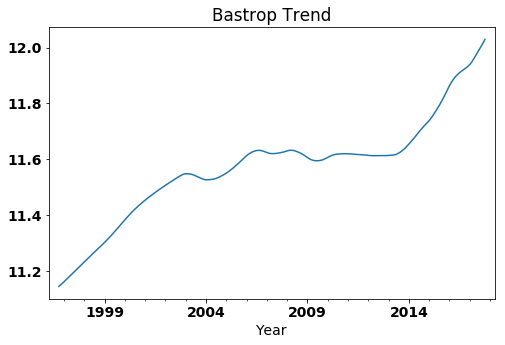

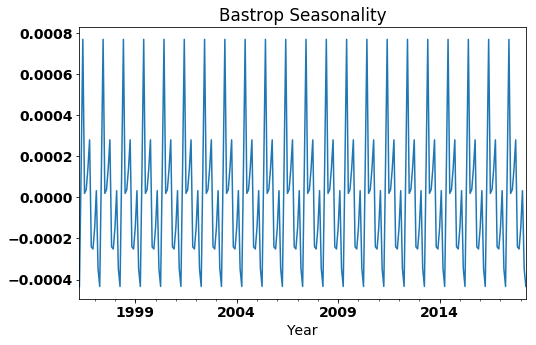

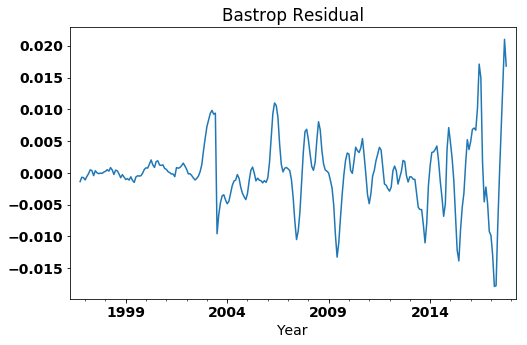

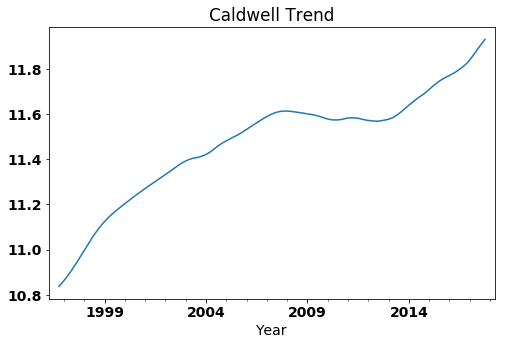

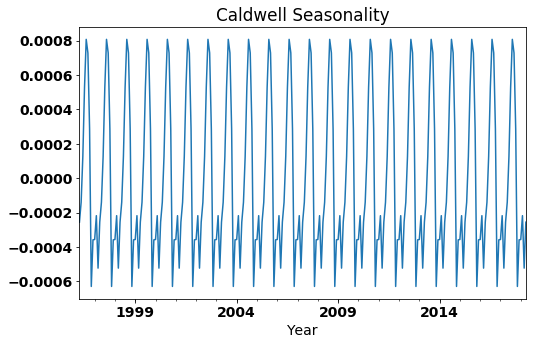

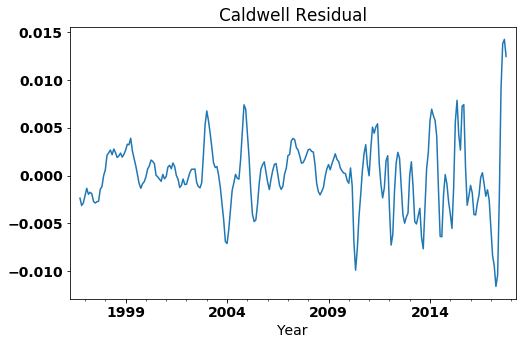

In [13]:
for county in summary_df.columns:
    trend[county].plot(figsize = (8,5))
    plt.title(county + ' Trend')
    plt.xlabel('Year')
    plt.show();

    seasonal[county].plot(figsize = (8,5))
    plt.title(county + ' Seasonality')
    plt.xlabel('Year')
    plt.show();

    residual[county].plot(figsize = (8,5))
    plt.title(county + ' Residual')
    plt.xlabel('Year')
    plt.show();

In [14]:
p = [0,1,2,3]
d = [0,1]
q = [0,1,2,3]

sp = [0,1,2]
sd = [0,1]
sq = [0,1,2]
s = [12]

In [15]:
results = get_SARIMA_parameters(train_df,p,d,q,sp,sd,sq,s)
results[0:5]

total combos =  576


C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so 

C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so 

C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information

C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so 

C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was prov

C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to co

C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimiz

C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information

C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so 

C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so 

C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information

C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was prov

C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information

C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so 

C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to co

C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization fai

C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information

C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information

C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimiz

C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was prov

C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information

C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimiz

[{'terms': (1, 1, 3),
  'seasonal terms': (0, 1, 2, 12),
  'AIC': 2160.630896707871},
 {'terms': (2, 1, 3),
  'seasonal terms': (0, 1, 2, 12),
  'AIC': 2161.6881084965066},
 {'terms': (1, 1, 3),
  'seasonal terms': (1, 1, 2, 12),
  'AIC': 2162.548600686134},
 {'terms': (2, 1, 3),
  'seasonal terms': (1, 1, 2, 12),
  'AIC': 2166.5107211001723},
 {'terms': (1, 1, 2),
  'seasonal terms': (0, 1, 2, 12),
  'AIC': 2173.5664098502575}]

In [16]:
pdq = (1, 1, 3)
pdqs = (0, 1, 2, 12)
model = run_SARIMAX(summary_df.Region, pdq, pdqs)['model']
model.summary()

C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             Region   No. Observations:                  265
Model:             SARIMAX(1, 1, 3)x(0, 1, 2, 12)   Log Likelihood               -1596.708
Date:                            Tue, 26 Nov 2019   AIC                           3207.416
Time:                                    21:37:52   BIC                           3231.298
Sample:                                04-01-1996   HQIC                          3217.056
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9613      0.028     34.813      0.000       0.907       1.015
ma.L1          0.1742      0.045      3.885      0.000       0.086       0.262
ma.L2         -0.1440      0.058     -2.501      0.012      -0.257      -0.031
ma.L3         -0.0875      0.080     -1.093      0.274      -0.244       0.069
ma.S.L12      -0.9674      0.140     -6.932      0.000      -1.241      -0.694
ma.S.L24       0.0181      0.084      0.216      0.829      -0.146       0.182
sigma2      8.299e+04   8503.719      9.759      0.000    6.63e+04    9.97e+04
===================================================================================
Ljung-Box (Q):                       42.34   Jarque-Bera (JB):              1036.85
Prob(Q):                              0.37   Prob(JB):                         0.00
Heteroskedasticity (H):               1.42   Skew:                             0.61
Prob(H) (two-sided):                  0.13   Kurtosis:                        13.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

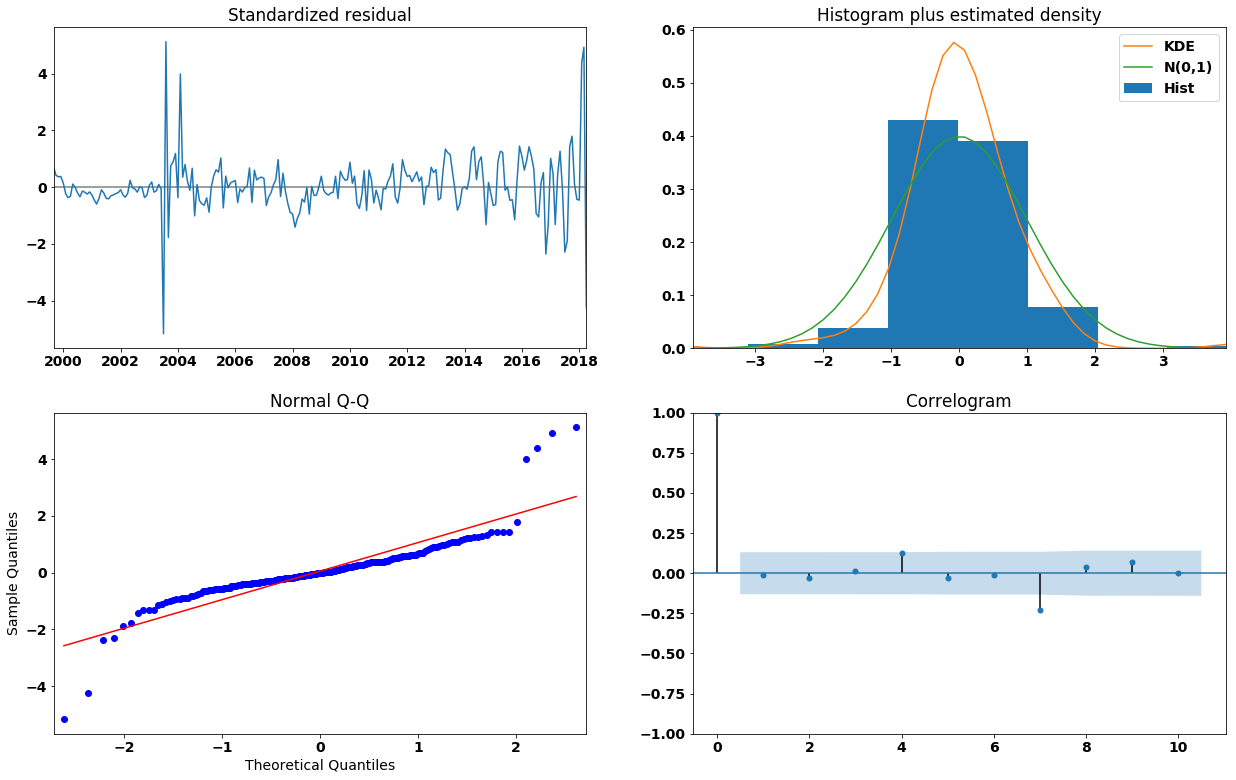

In [17]:
model.plot_diagnostics(figsize = (21,13));

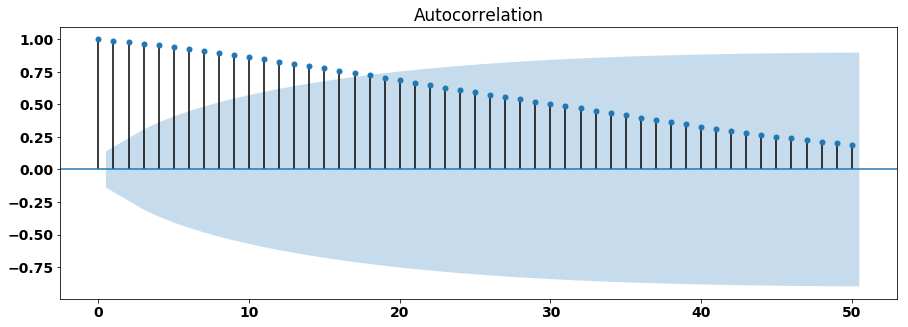

In [18]:
acf_plot(train_df, lags = 50)

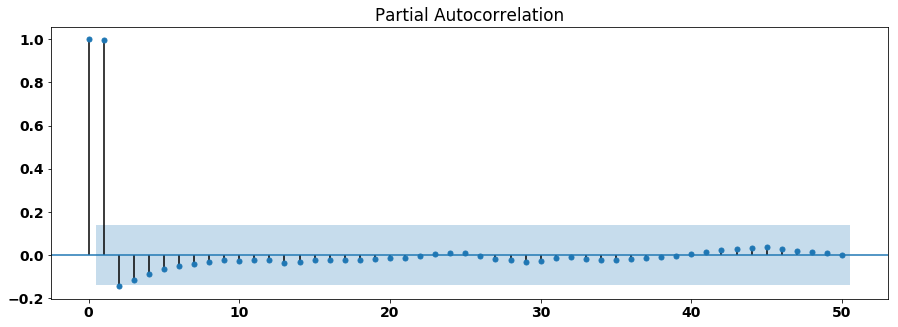

In [19]:
pacf_plot(train_df, lags = 50)

RMSE:  538.361833635564


Text(0, 0.5, 'Mean Sale Price')

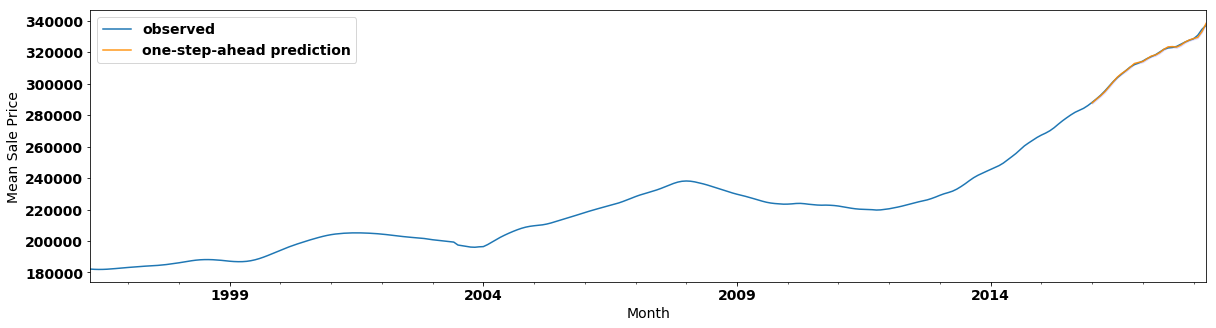

In [27]:
plot_prediction(summary_df.Region, model, '2016', dynamic=False)
plt.ylabel('Mean Sale Price')

RMSE:  8733.33768675742


Text(0, 0.5, 'Mean Sale Price')

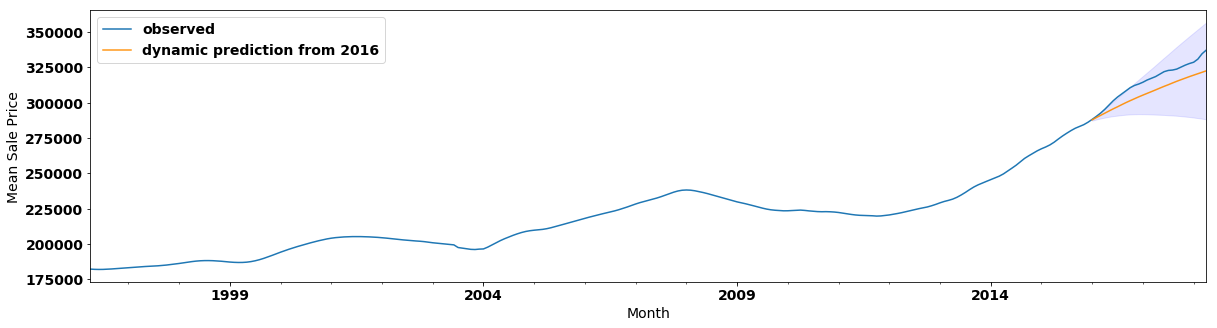

In [26]:
plot_prediction(summary_df.Region, model, '2016', dynamic=True)
plt.ylabel('Mean Sale Price')

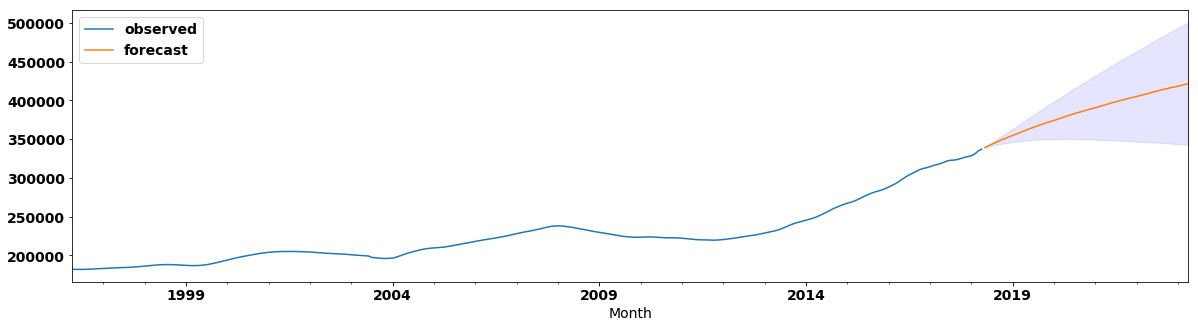

{'ROI_1yr': 0.068, 'ROI_5yr': 0.251}

In [28]:
get_forecast(summary_df.Region, model, 60, plot = True)

In [29]:
results = []
steps = 60
for zc in austin_df.columns:
    model = run_SARIMAX(austin_df[zc], pdq, pdqs)['model']
    result = get_forecast(austin_df[zc], model, steps, plot = False)
    result['zipcode'] = zc
    result['model'] = model
    location = data.loc[data.RegionName == zc, ['City', 'State', 'CountyName']].values
    result['city'] = f"{location[0][0]}, {location[0][1]}"
    result['county'] = location[0][2]
    results.append(result)
results = sorted(results, key = lambda x: x['ROI_5yr'], reverse = True)

C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so 

C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so 

C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Drew\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization fai

In [30]:
results_df = pd.DataFrame(results)
results_df.drop(columns = ['model'], inplace = True)
results_df.head()

ROI_1yr  ROI_5yr  zipcode             city   county
0    0.119    0.757    78733       Austin, TX   Travis
1    0.116    0.654    78612  Cedar Creek, TX  Bastrop
2    0.099    0.497    78616  Cedar Creek, TX  Bastrop
3    0.094    0.425    78731       Austin, TX   Travis
4    0.091    0.391    78741       Austin, TX   Travis

Austin, TX


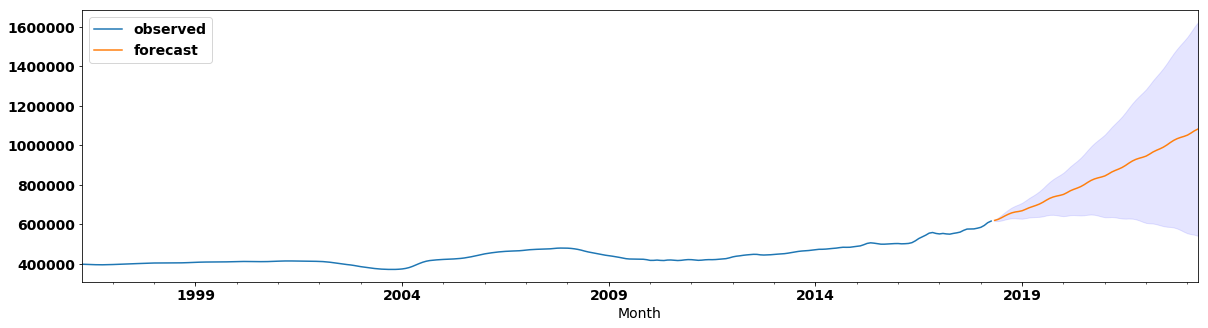

Cedar Creek, TX


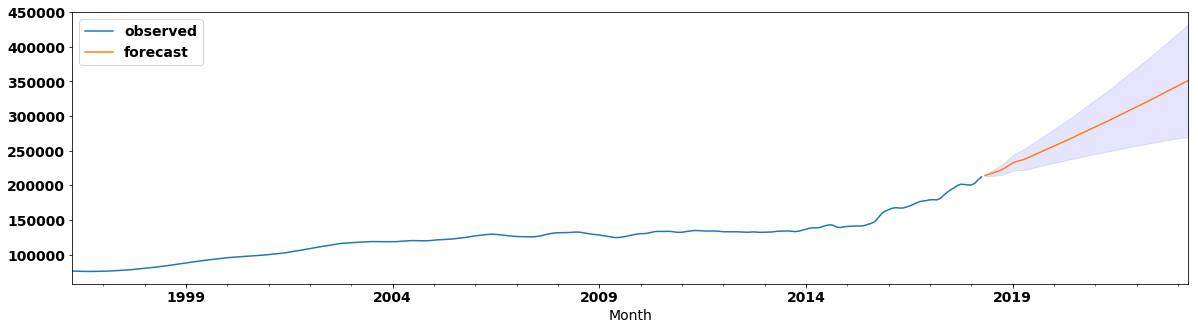

Cedar Creek, TX


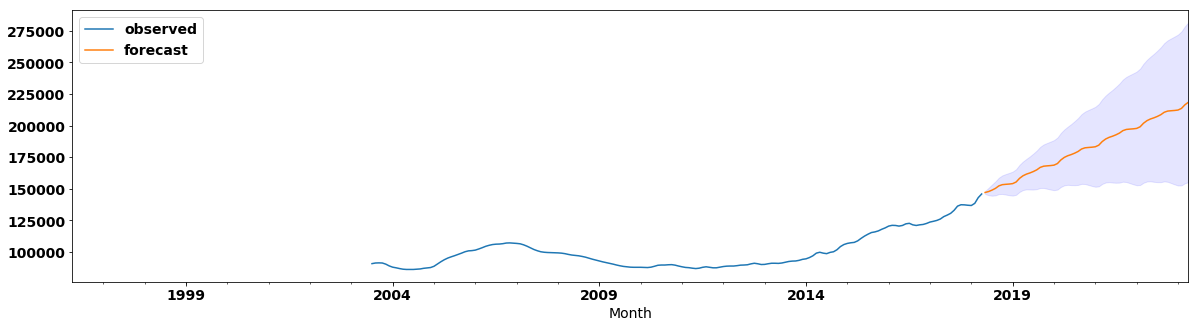

Austin, TX


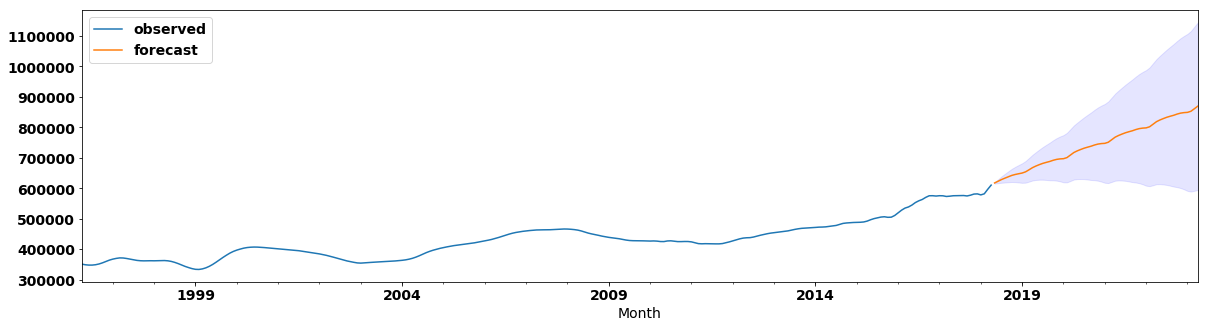

Austin, TX


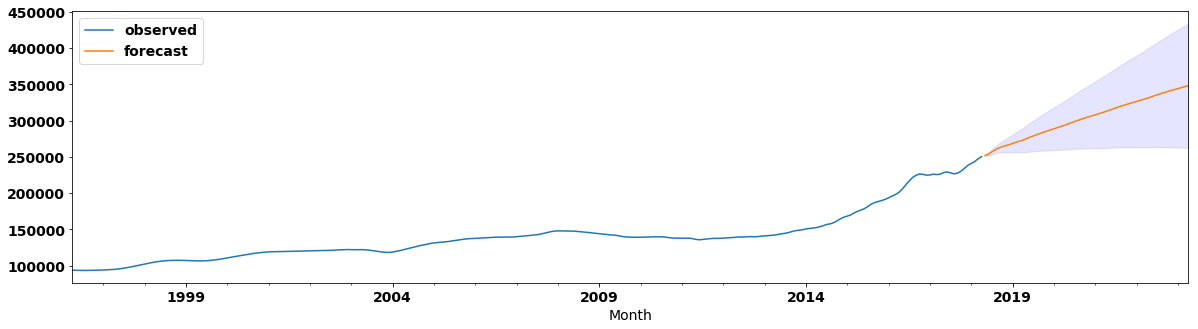

In [31]:
for result in results[:5]:
    print(result['city'])
    get_forecast(austin_df[result['zipcode']], result['model'], 60, plot = True)

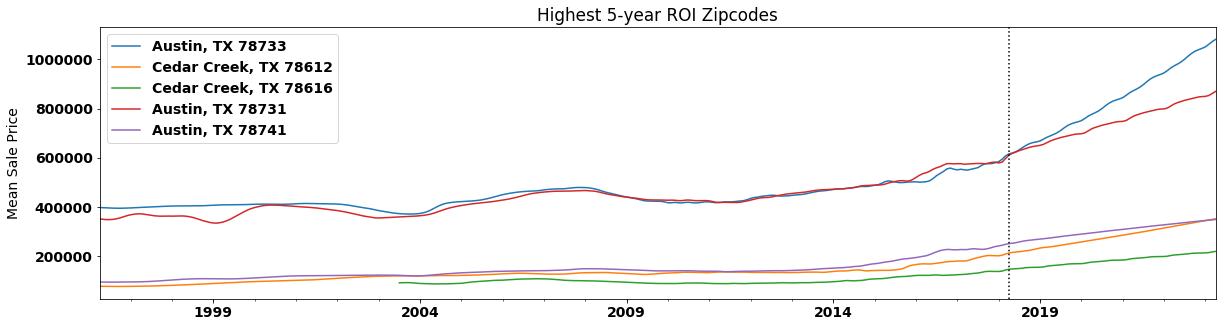

In [32]:
plt.ylabel('Mean Sale Price')
plot_forecasts(austin_df, results[:5], steps = 60, title = 'Highest 5-year ROI Zipcodes')

In [33]:
results_df.tail()

ROI_1yr  ROI_5yr  zipcode            city      county
68    0.010    0.090    78634       Hutto, TX  Williamson
69   -0.020    0.075    76574      Taylor, TX  Williamson
70   -0.004    0.067    78739      Austin, TX      Travis
71   -0.019    0.060    78613  Cedar Park, TX  Williamson
72   -0.005    0.054    78665  Round Rock, TX  Williamson

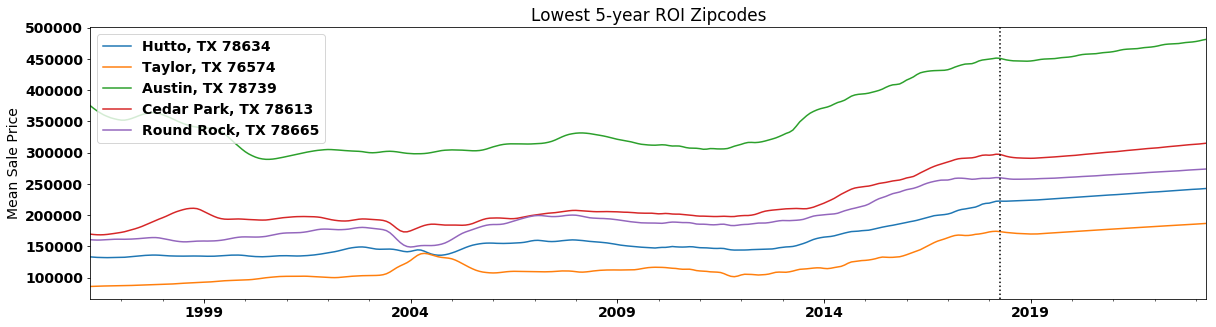

In [34]:
plt.ylabel('Mean Sale Price')
plot_forecasts(austin_df, results[-5:], steps = 60, title = 'Lowest 5-year ROI Zipcodes')

# Secondary Conclusion

From our original results, looking at the largest 5-year return on investment, the best five zip codes were 78612, 78676, 78741, 78957, and 78758, in that order. Meanwhile, the five worst zip codes for 5-year ROI were 78735, 78653, 78665, 78733 and 78613, in that order.

Using the full dataset, oddly enough our second worst zip code, 78733, jumped all the way to the top, while 78612 moved down one spot and 78741 moved down a couple, putting our top five largest 5-year return on investment zip codes as 78733, 78612, 78616, 78731, and 78741 in that order. On the other end, 78613 gained one spot, while 78665 fell to the bottom, putting our worst five investment zip codes as 78634, 76574, 78739, 78613, and 78665 in that order.

I feel a bit better about this secondary result, based on the rest of my plotting, mainly that my PACF plot didn't have that odd spike around the 30 lag mark, however, my model's AIC was much much higher, and the kurtosis of my residuals was quite a bit higher as well. I still feel like there's more that I can perfect about this model, but for an "I want to come back and add this to my project" section, I really like how it came out.